# Eval runs

In [9]:
#! pip install pandas
#! pip install matplotlib
#! pip install scipy
#! pip install seaborn
#! pip install nbconvert
#! pip install matplotlib-venn
! jupyter nbconvert --to HTML PoseErrorAnalysis.ipynb

[NbConvertApp] Converting notebook PoseErrorAnalysis.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 8565732 bytes to PoseErrorAnalysis.html


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from PIL import Image 
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append("../")  # from src/notebooks to src/

from util.datapipeline.EmbeddingDataset import EmbeddingDataset

pd.set_option('display.max_columns', None)

In [11]:

dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-edgeface", disable_tqdm=False)

Loading classes: 100%|██████████| 1041/1041 [03:33<00:00,  4.87it/s]


In [12]:
def compute_average_heatmaps(
    dataset,
    center_pose=(0, 0),
    B_ratio=50,
    visualize=True
):
    device = dataset[0][0].device
    N = len(dataset)

    # ------------------------------------------------------------
    # Pose grid (from first sample, assumed consistent)
    # ------------------------------------------------------------
    _, _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])

    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # ------------------------------------------------------------
    # Pose → heatmap index mapping (for visualization)
    # ------------------------------------------------------------
    pitch_to_idx = {p: i for i, p in enumerate(pitches)}
    yaw_to_idx   = {y: j for j, y in enumerate(yaws)}

    pose_y = np.array([pitch_to_idx[p] for p, _ in poses_ref])
    pose_x = np.array([yaw_to_idx[y]   for _, y in poses_ref])

    # ------------------------------------------------------------
    # Precompute labels + center pose indices
    # ------------------------------------------------------------
    labels = np.empty(N, dtype=np.int32)
    center_indices = np.full(N, -1, dtype=np.int32)

    for i, (_, label, _, _, poses, _) in enumerate(
        tqdm(dataset, desc="Prepare Dataset")
    ):
        labels[i] = label
        poses = [tuple(map(int, p)) for p in poses]

        if center_pose in poses:
            center_indices[i] = poses.index(center_pose)

    # ------------------------------------------------------------
    # Random B sampling
    # ------------------------------------------------------------
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # ------------------------------------------------------------
    # Accumulators
    # ------------------------------------------------------------
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # ------------------------------------------------------------
    # Main loop
    # ------------------------------------------------------------
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            center_idx = center_indices[j]
            if center_idx < 0:
                continue

            emb_j, _, _, _, _, _ = dataset[j]
            emb_center = F.normalize(emb_j[center_idx], dim=-1)

            sims = torch.matmul(emb_a, emb_center).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # ------------------------------------------------------------
    # Average in pose space
    # ------------------------------------------------------------
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # ------------------------------------------------------------
    # Interpolation
    # ------------------------------------------------------------
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # ------------------------------------------------------------
    # NaN handling
    # ------------------------------------------------------------
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = np.nanmean(heat_same)

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = np.nanmean(heat_diff)

    # ------------------------------------------------------------
    # Visualization
    # ------------------------------------------------------------
    if visualize:
        plt.figure(figsize=(27, 14))

        # SAME LABEL
        plt.subplot(1, 2, 1)
        sns.heatmap(
            heat_same,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap="viridis",
            square=True,
            annot=True,
            fmt=".0f",
            annot_kws={"size": 6},
            alpha=0.9
        )
        plt.scatter(
            pose_x, pose_y,
            s=14,
            c="white",
            edgecolors="black",
            linewidths=0.3,
            alpha=0.95
        )
        plt.title("Average Similarity — Same Label", fontsize=14)

        # DIFFERENT LABEL
        plt.subplot(1, 2, 2)
        sns.heatmap(
            heat_diff,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap="viridis",
            square=True,
            annot=True,
            fmt=".0f",
            annot_kws={"size": 6},
            alpha=0.9
        )
        plt.scatter(
            pose_x, pose_y,
            s=14,
            c="white",
            edgecolors="black",
            linewidths=0.3,
            alpha=0.95
        )
        plt.title("Average Similarity — Different Label", fontsize=14)

        plt.tight_layout()
        plt.show()

    return heat_same, heat_diff, pitches, yaws


Compute distances: 100%|██████████| 19786/19786 [08:51<00:00, 37.21it/s]


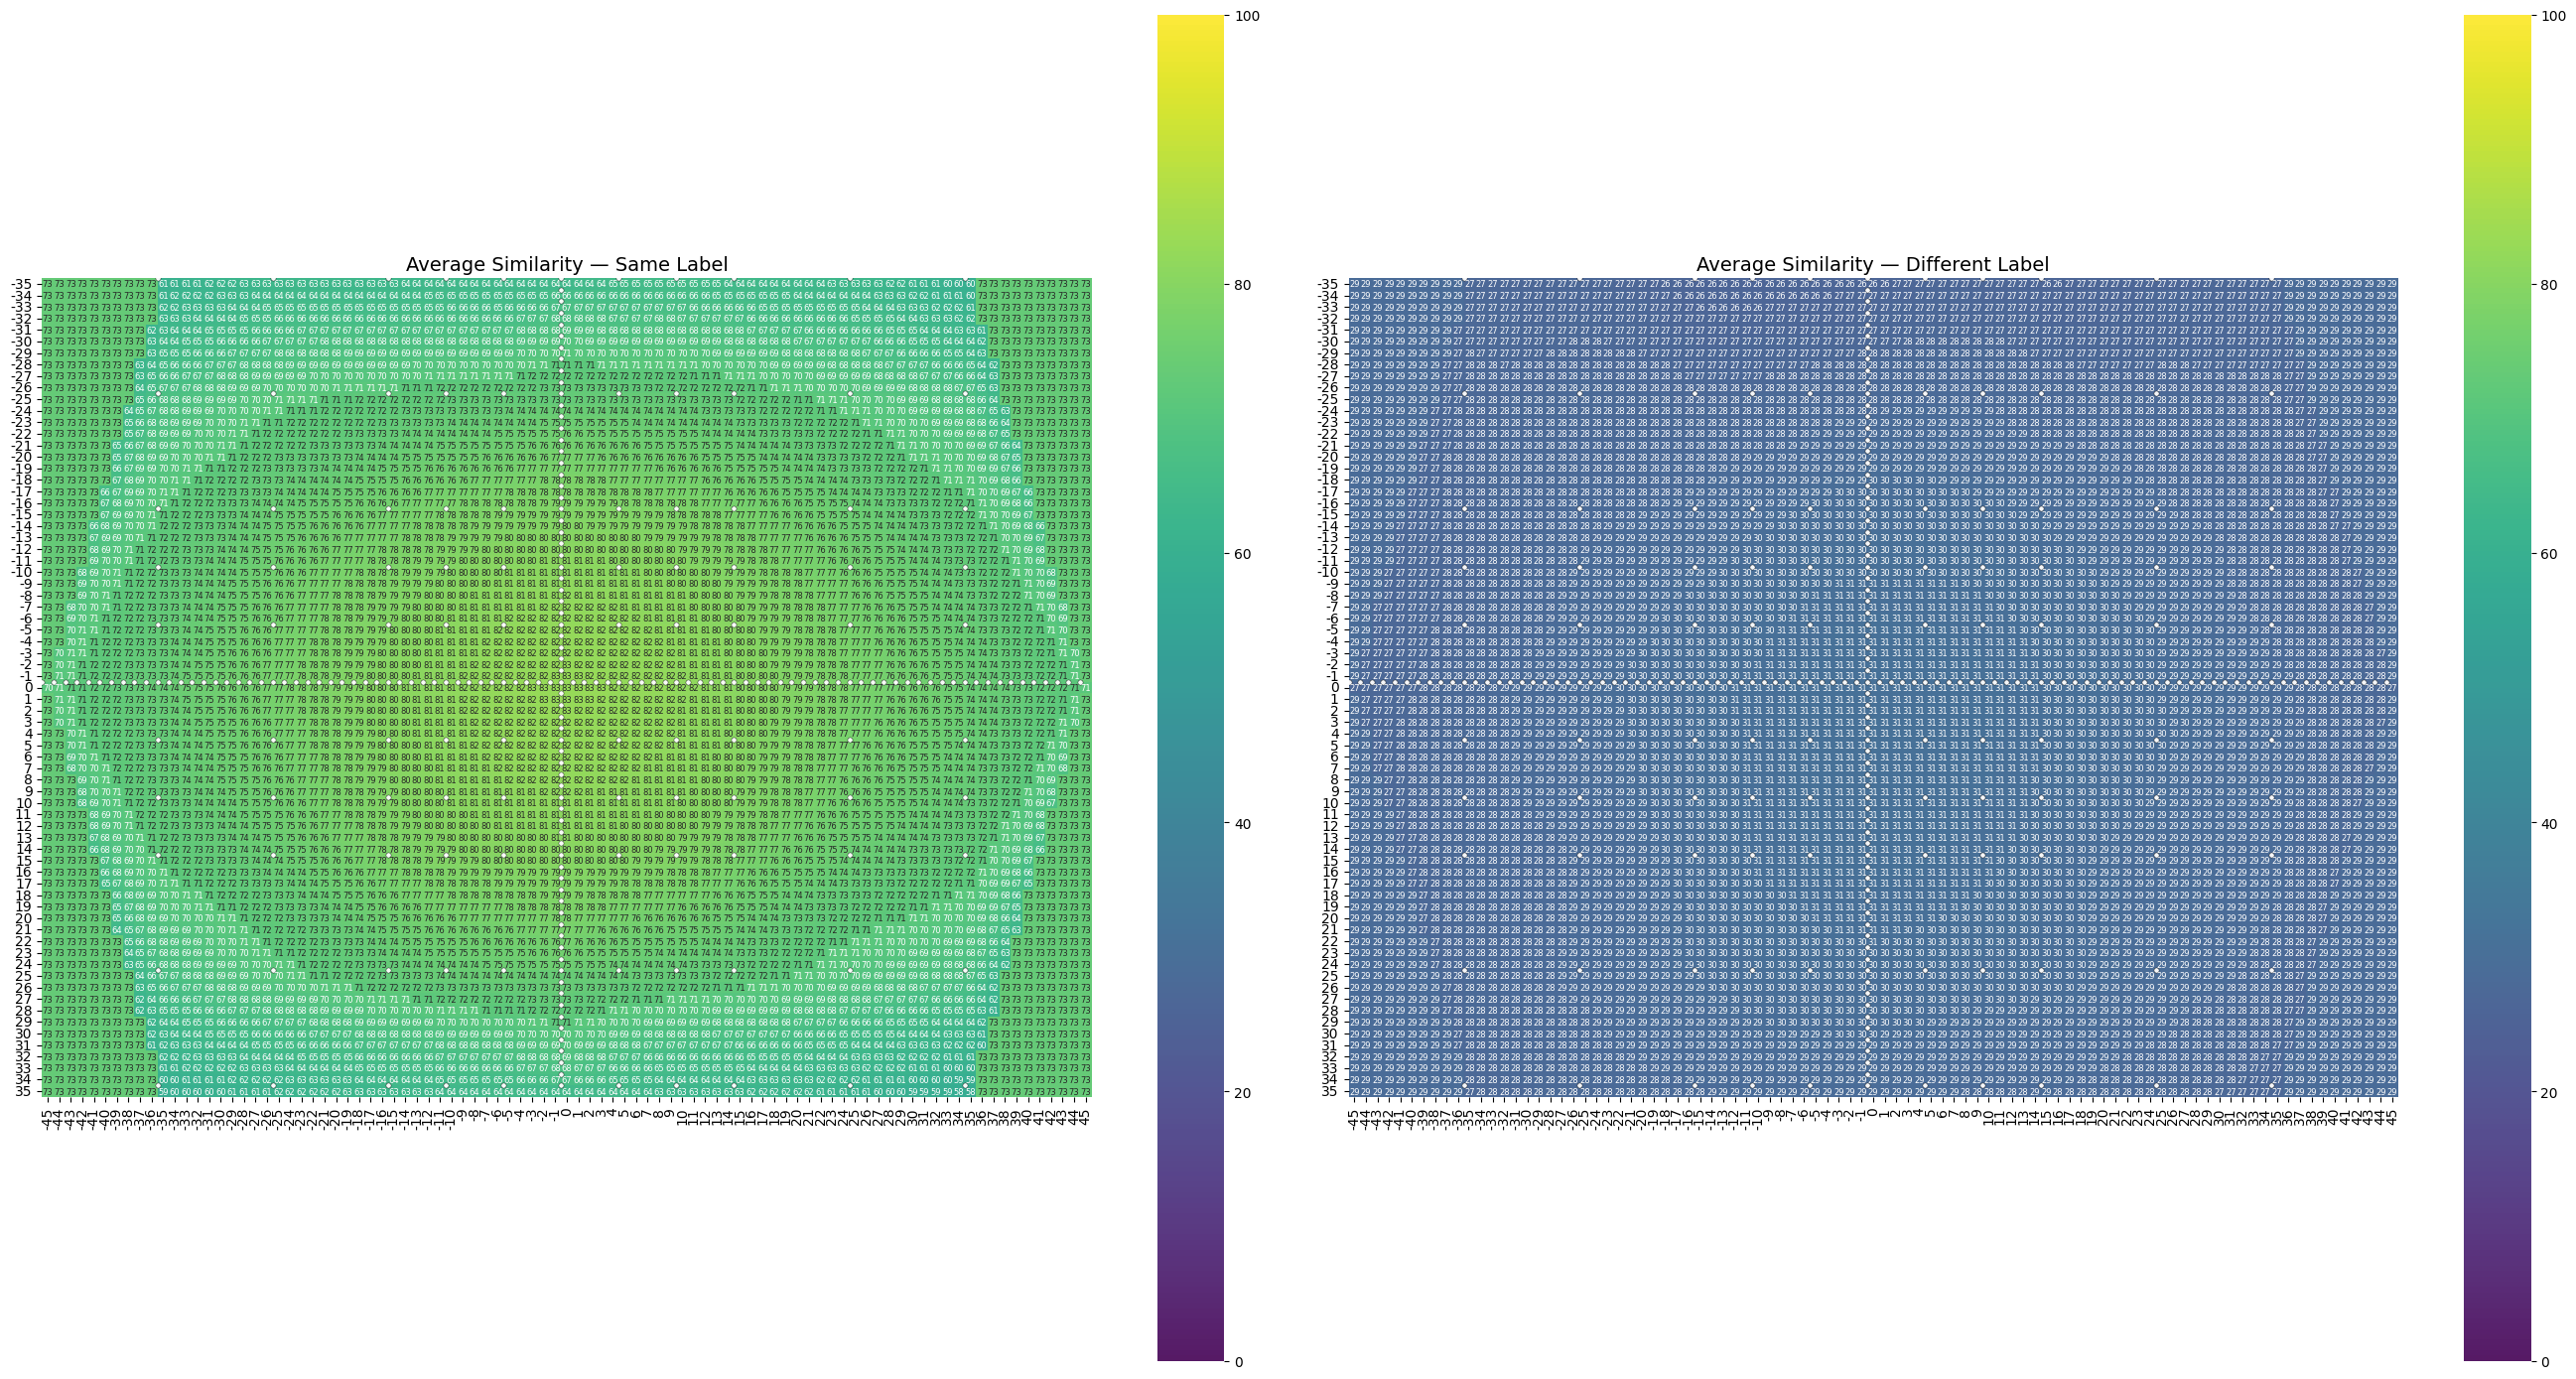

In [13]:
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), visualize=True)

### Headpose aligned comparison

In [14]:
def compute_average_heatmaps_pairwise(dataset, B_ratio=50, visualize=True):
    device = dataset[0][0].device
    N = len(dataset)

    # ------------------------------------------------------------
    # Pose grid (from first sample, assumed consistent)
    # ------------------------------------------------------------
    _, _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])

    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # ------------------------------------------------------------
    # Pose → heatmap index mapping (for visualization)
    # ------------------------------------------------------------
    pitch_to_idx = {p: i for i, p in enumerate(pitches)}
    yaw_to_idx   = {y: j for j, y in enumerate(yaws)}

    pose_y = np.array([pitch_to_idx[p] for p, _ in poses_ref])
    pose_x = np.array([yaw_to_idx[y]   for _, y in poses_ref])

    # ------------------------------------------------------------
    # Precompute labels
    # ------------------------------------------------------------
    labels = np.empty(N, dtype=np.int32)
    for i, (_, label, _, _, _, _) in enumerate(tqdm(dataset, desc="Prepare Dataset")):
        labels[i] = label

    # ------------------------------------------------------------
    # Random B sampling
    # ------------------------------------------------------------
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # ------------------------------------------------------------
    # Accumulators
    # ------------------------------------------------------------
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # ------------------------------------------------------------
    # Main loop
    # ------------------------------------------------------------
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            emb_b, _, _, _, _, _ = dataset[j]
            emb_b = F.normalize(emb_b, dim=-1)

            sims = (emb_a * emb_b).sum(dim=-1).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # ------------------------------------------------------------
    # Average
    # ------------------------------------------------------------
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # ------------------------------------------------------------
    # Interpolation
    # ------------------------------------------------------------
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # ------------------------------------------------------------
    # NaN handling
    # ------------------------------------------------------------
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = np.nanmean(heat_same)

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = np.nanmean(heat_diff)

    # ------------------------------------------------------------
    # Visualization
    # ------------------------------------------------------------
    if visualize:
        plt.figure(figsize=(27, 14))

        # SAME LABEL
        plt.subplot(1, 2, 1)
        sns.heatmap(
            heat_same,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap="viridis",
            square=True,
            annot=True,
            fmt=".0f",
            annot_kws={"size": 6},
            alpha=0.9
        )
        plt.scatter(
            pose_x, pose_y,
            s=14, c="white",
            edgecolors="black",
            linewidths=0.3,
            alpha=0.95
        )
        plt.title("Average Similarity — Same Label", fontsize=14)

        # DIFFERENT LABEL
        plt.subplot(1, 2, 2)
        sns.heatmap(
            heat_diff,
            xticklabels=yaws,
            yticklabels=pitches,
            vmin=0,
            vmax=100,
            cmap="viridis",
            square=True,
            annot=True,
            fmt=".0f",
            annot_kws={"size": 6},
            alpha=0.9
        )
        plt.scatter(
            pose_x, pose_y,
            s=14, c="white",
            edgecolors="black",
            linewidths=0.3,
            alpha=0.95
        )
        plt.title("Average Similarity — Different Label", fontsize=14)

        plt.tight_layout()
        plt.show()

    return heat_same, heat_diff, pitches, yaws


Compute distances: 100%|██████████| 19786/19786 [14:22<00:00, 22.93it/s]


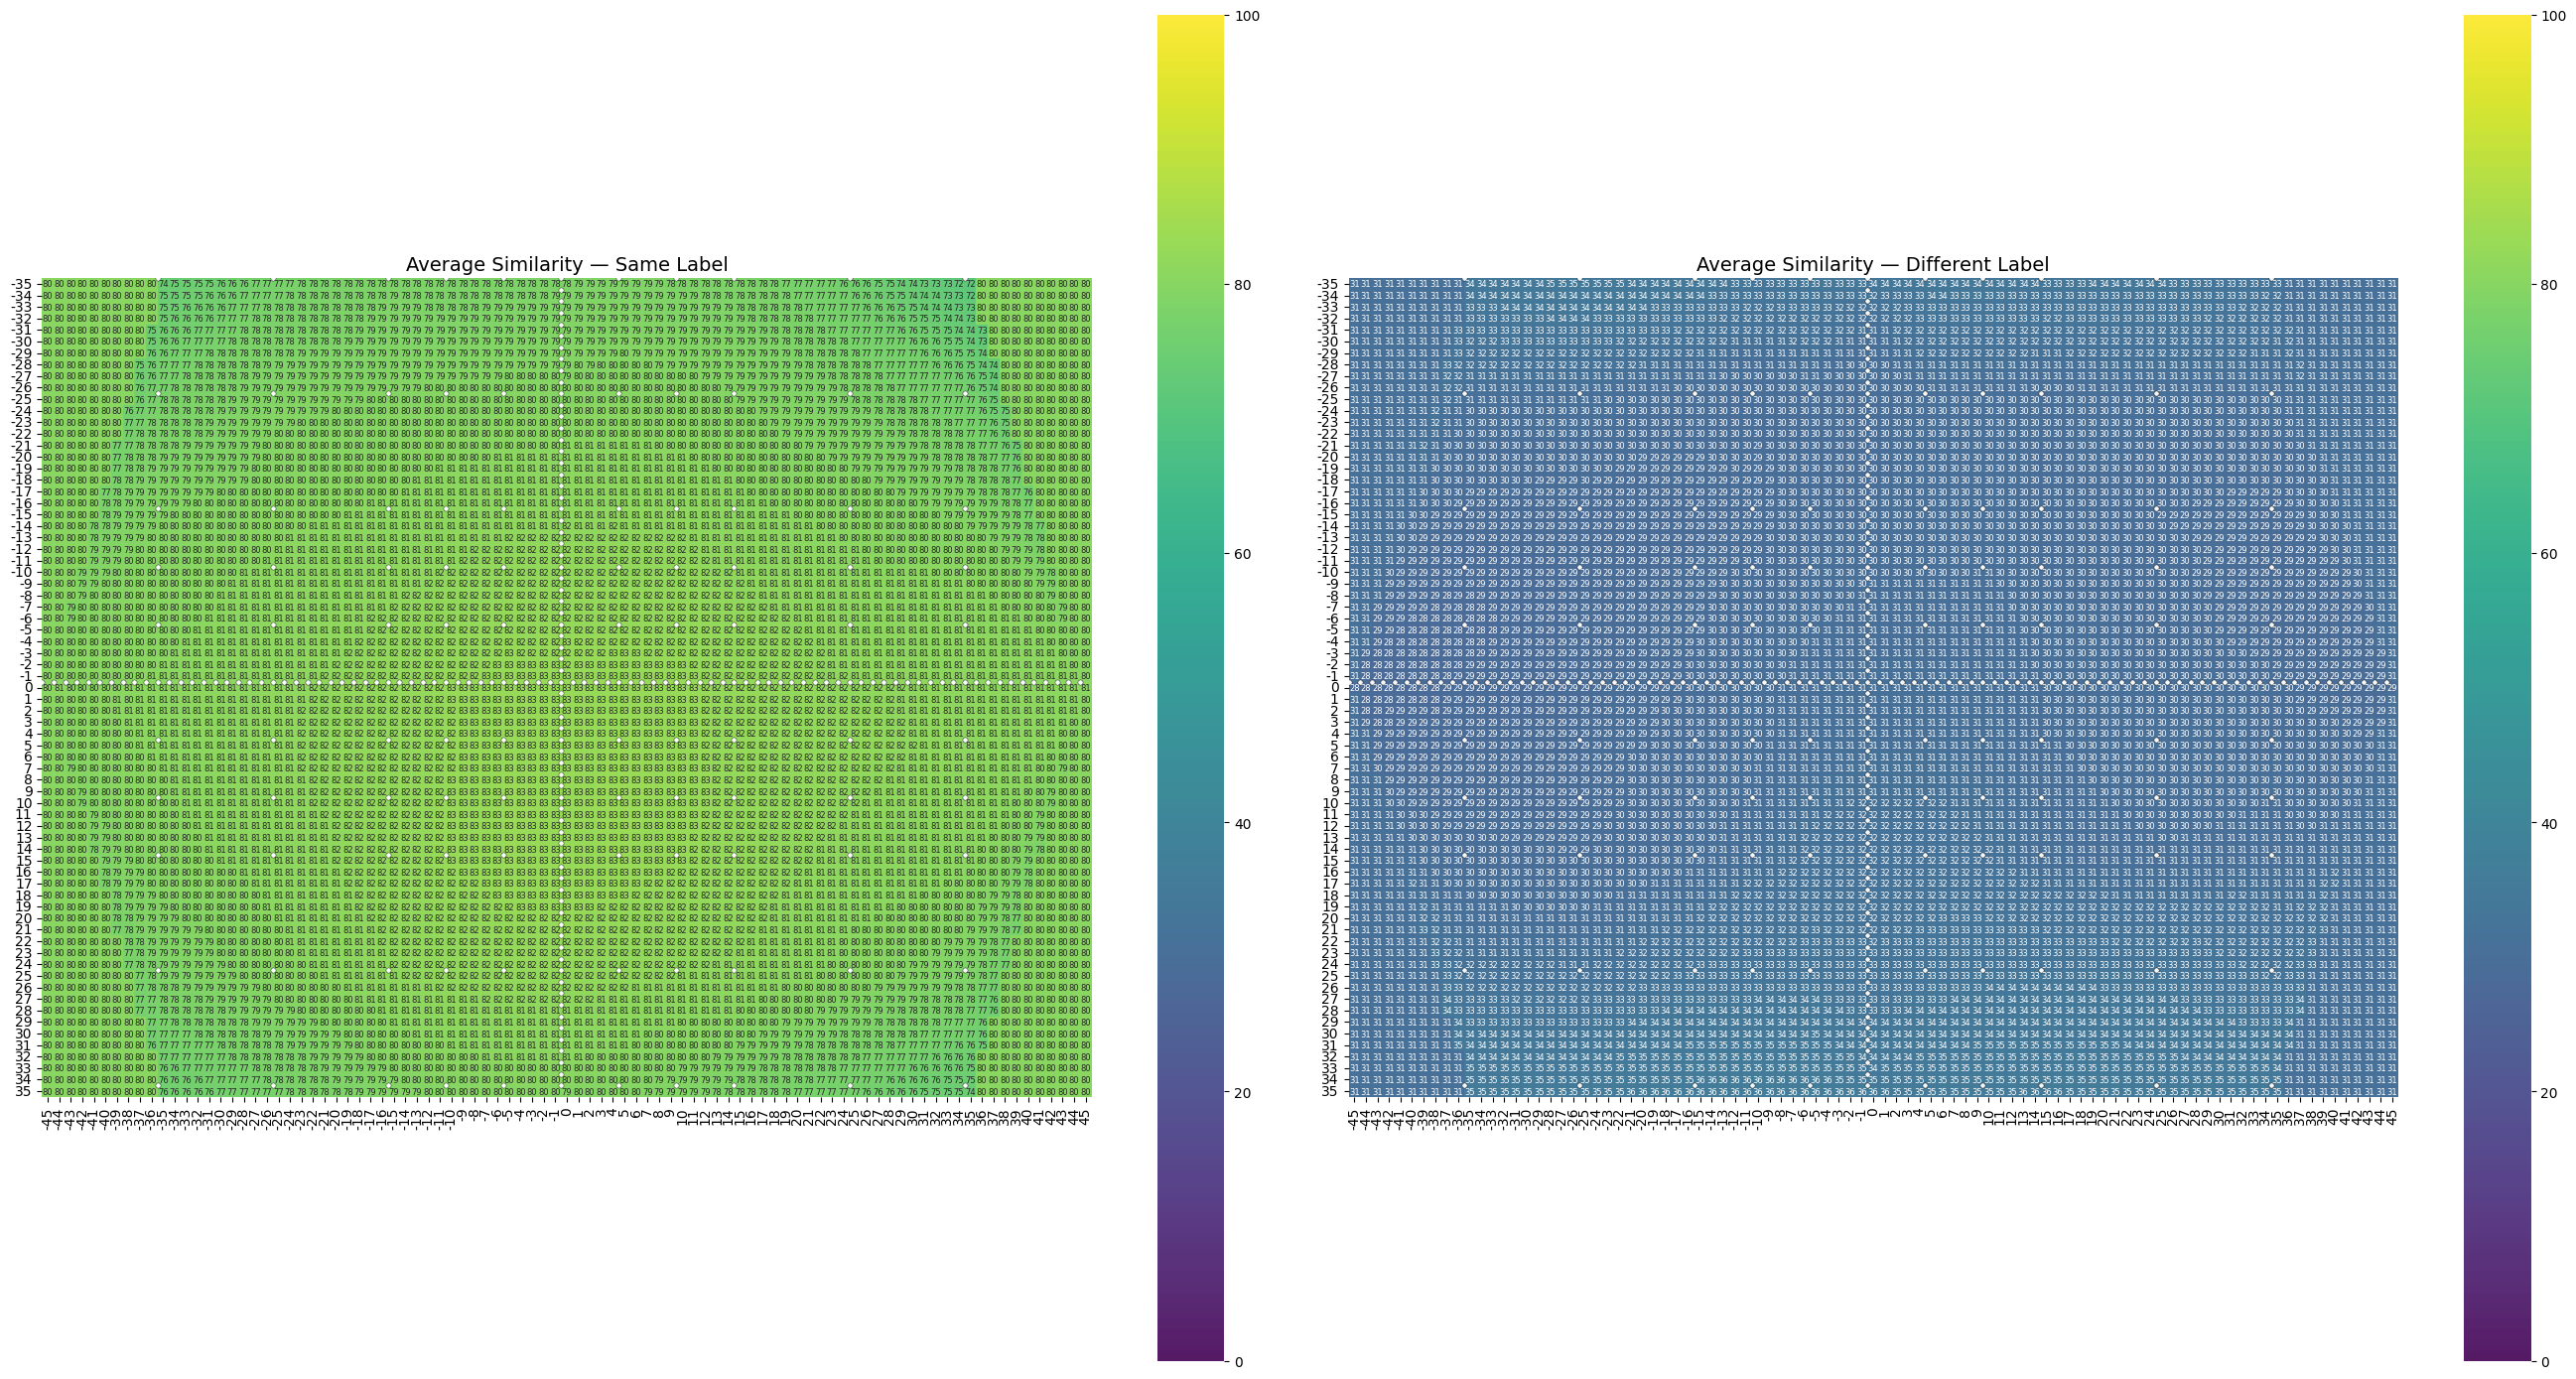

In [15]:
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [09:15<00:00, 35.63it/s]


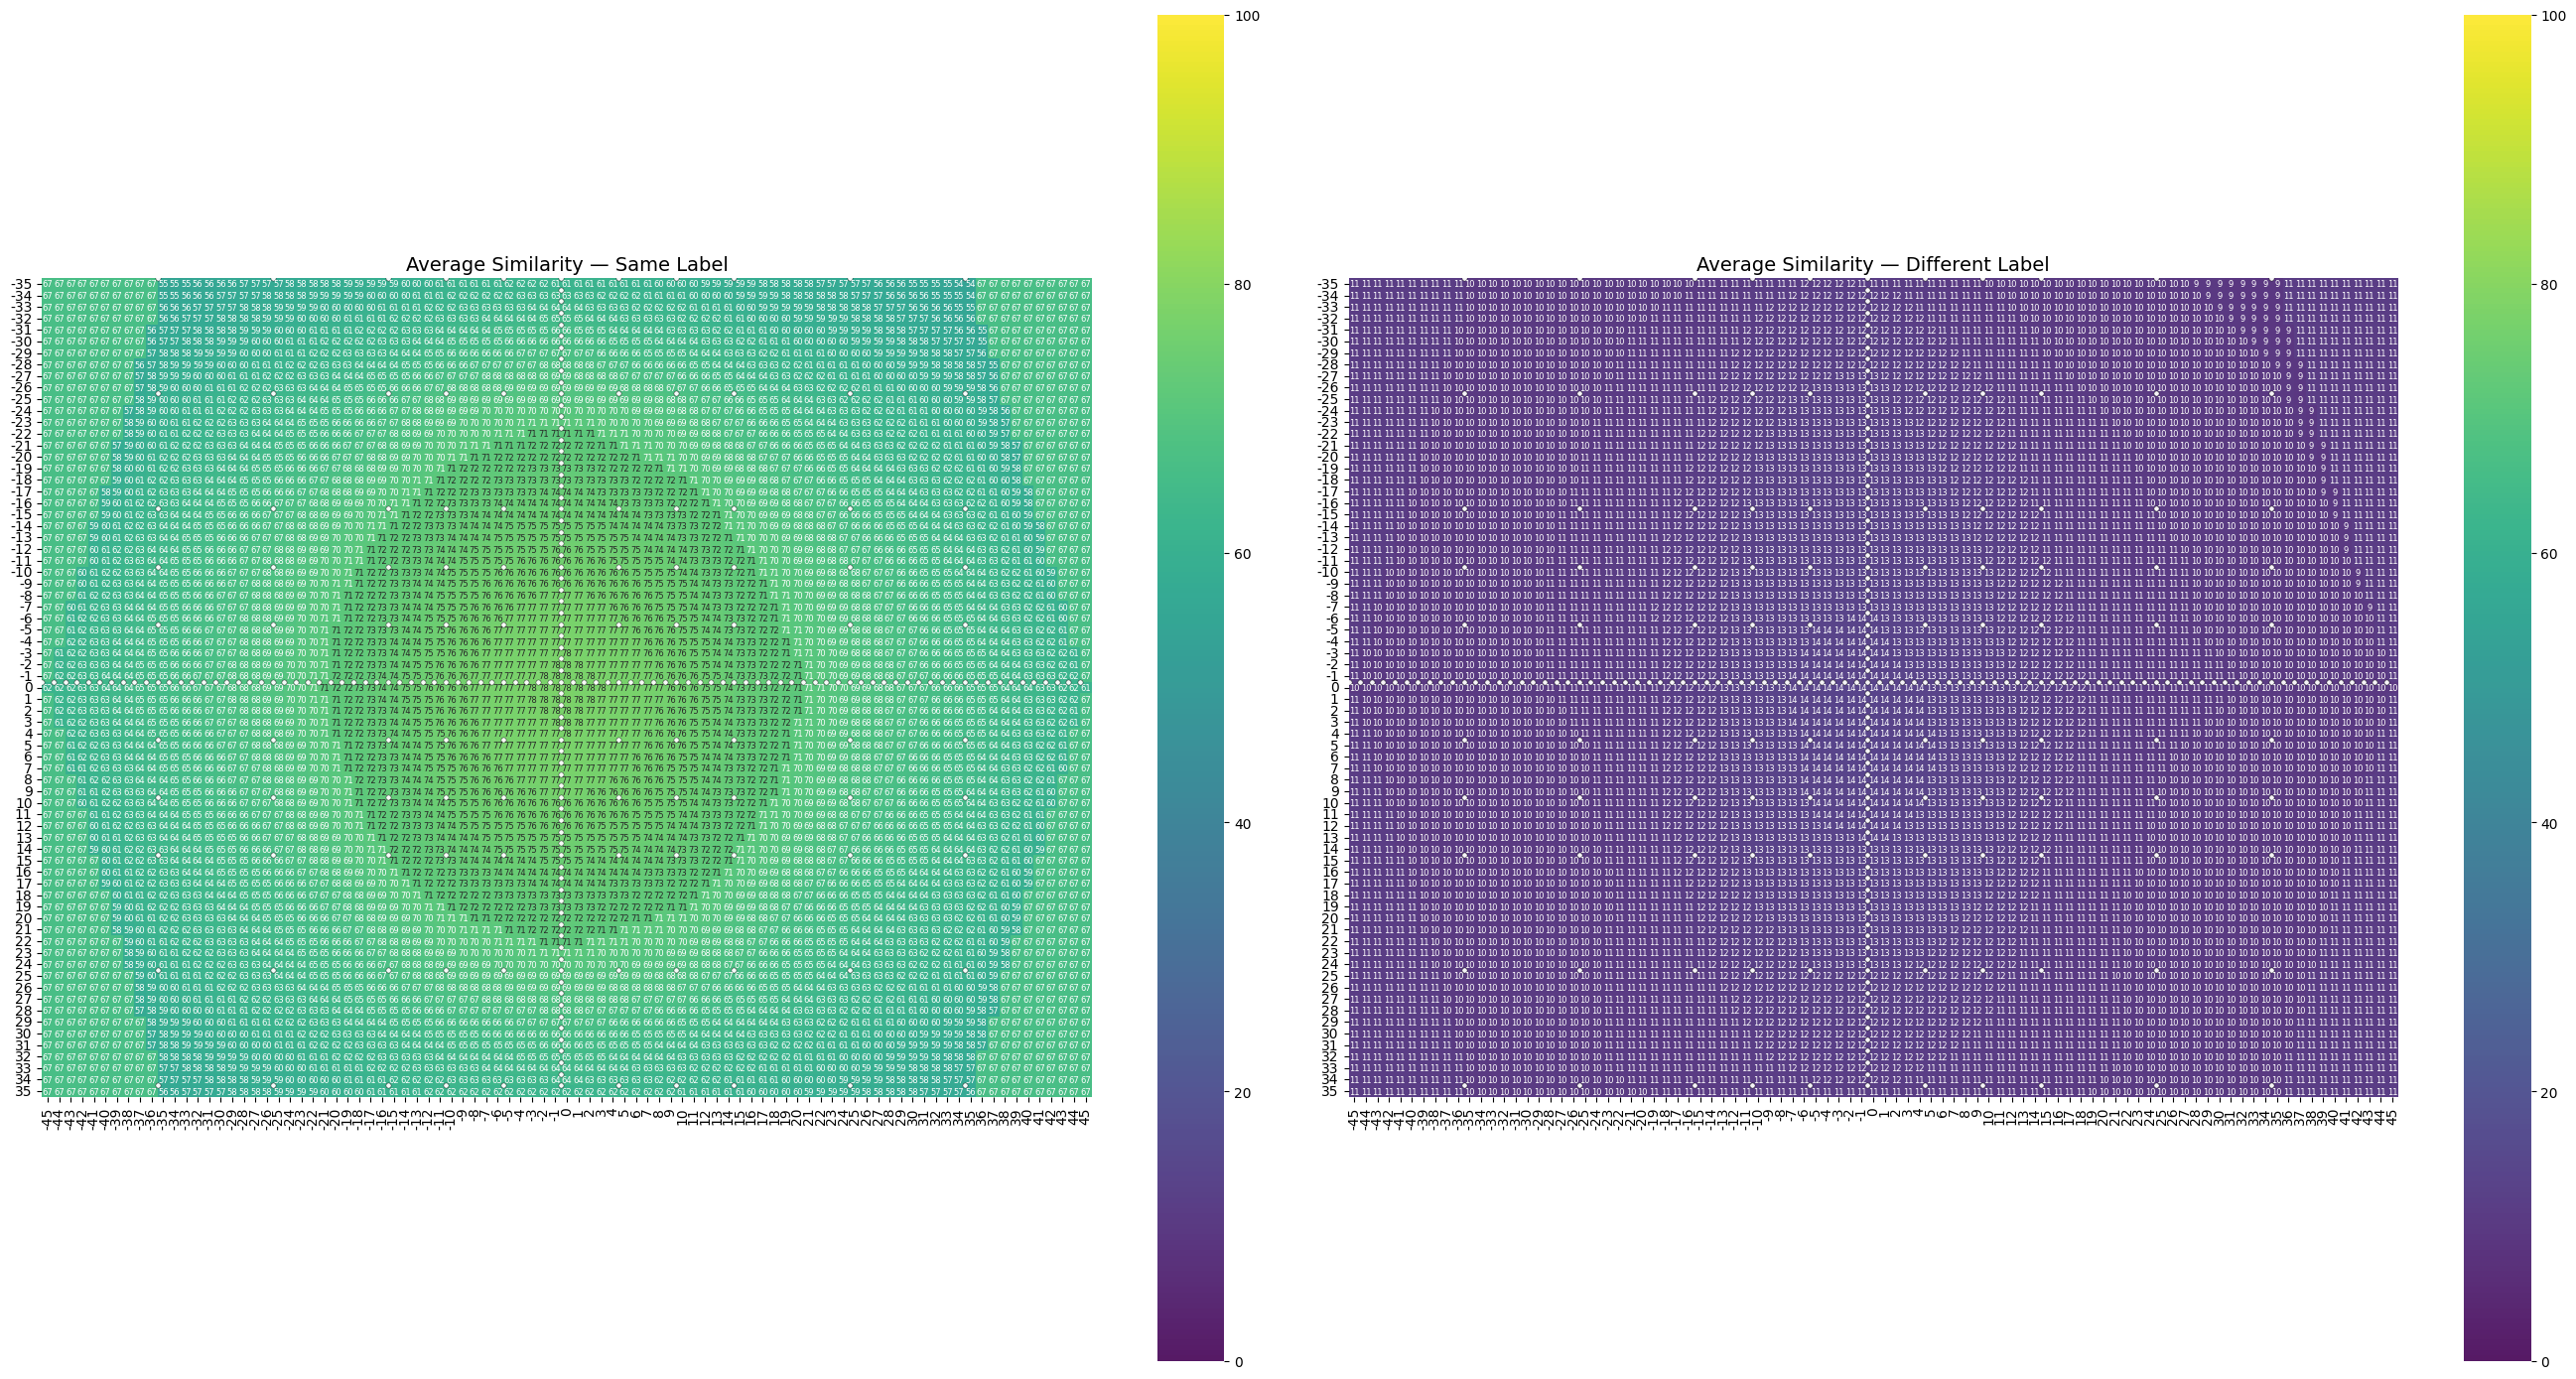

Compute distances: 100%|██████████| 19786/19786 [14:06<00:00, 23.37it/s]


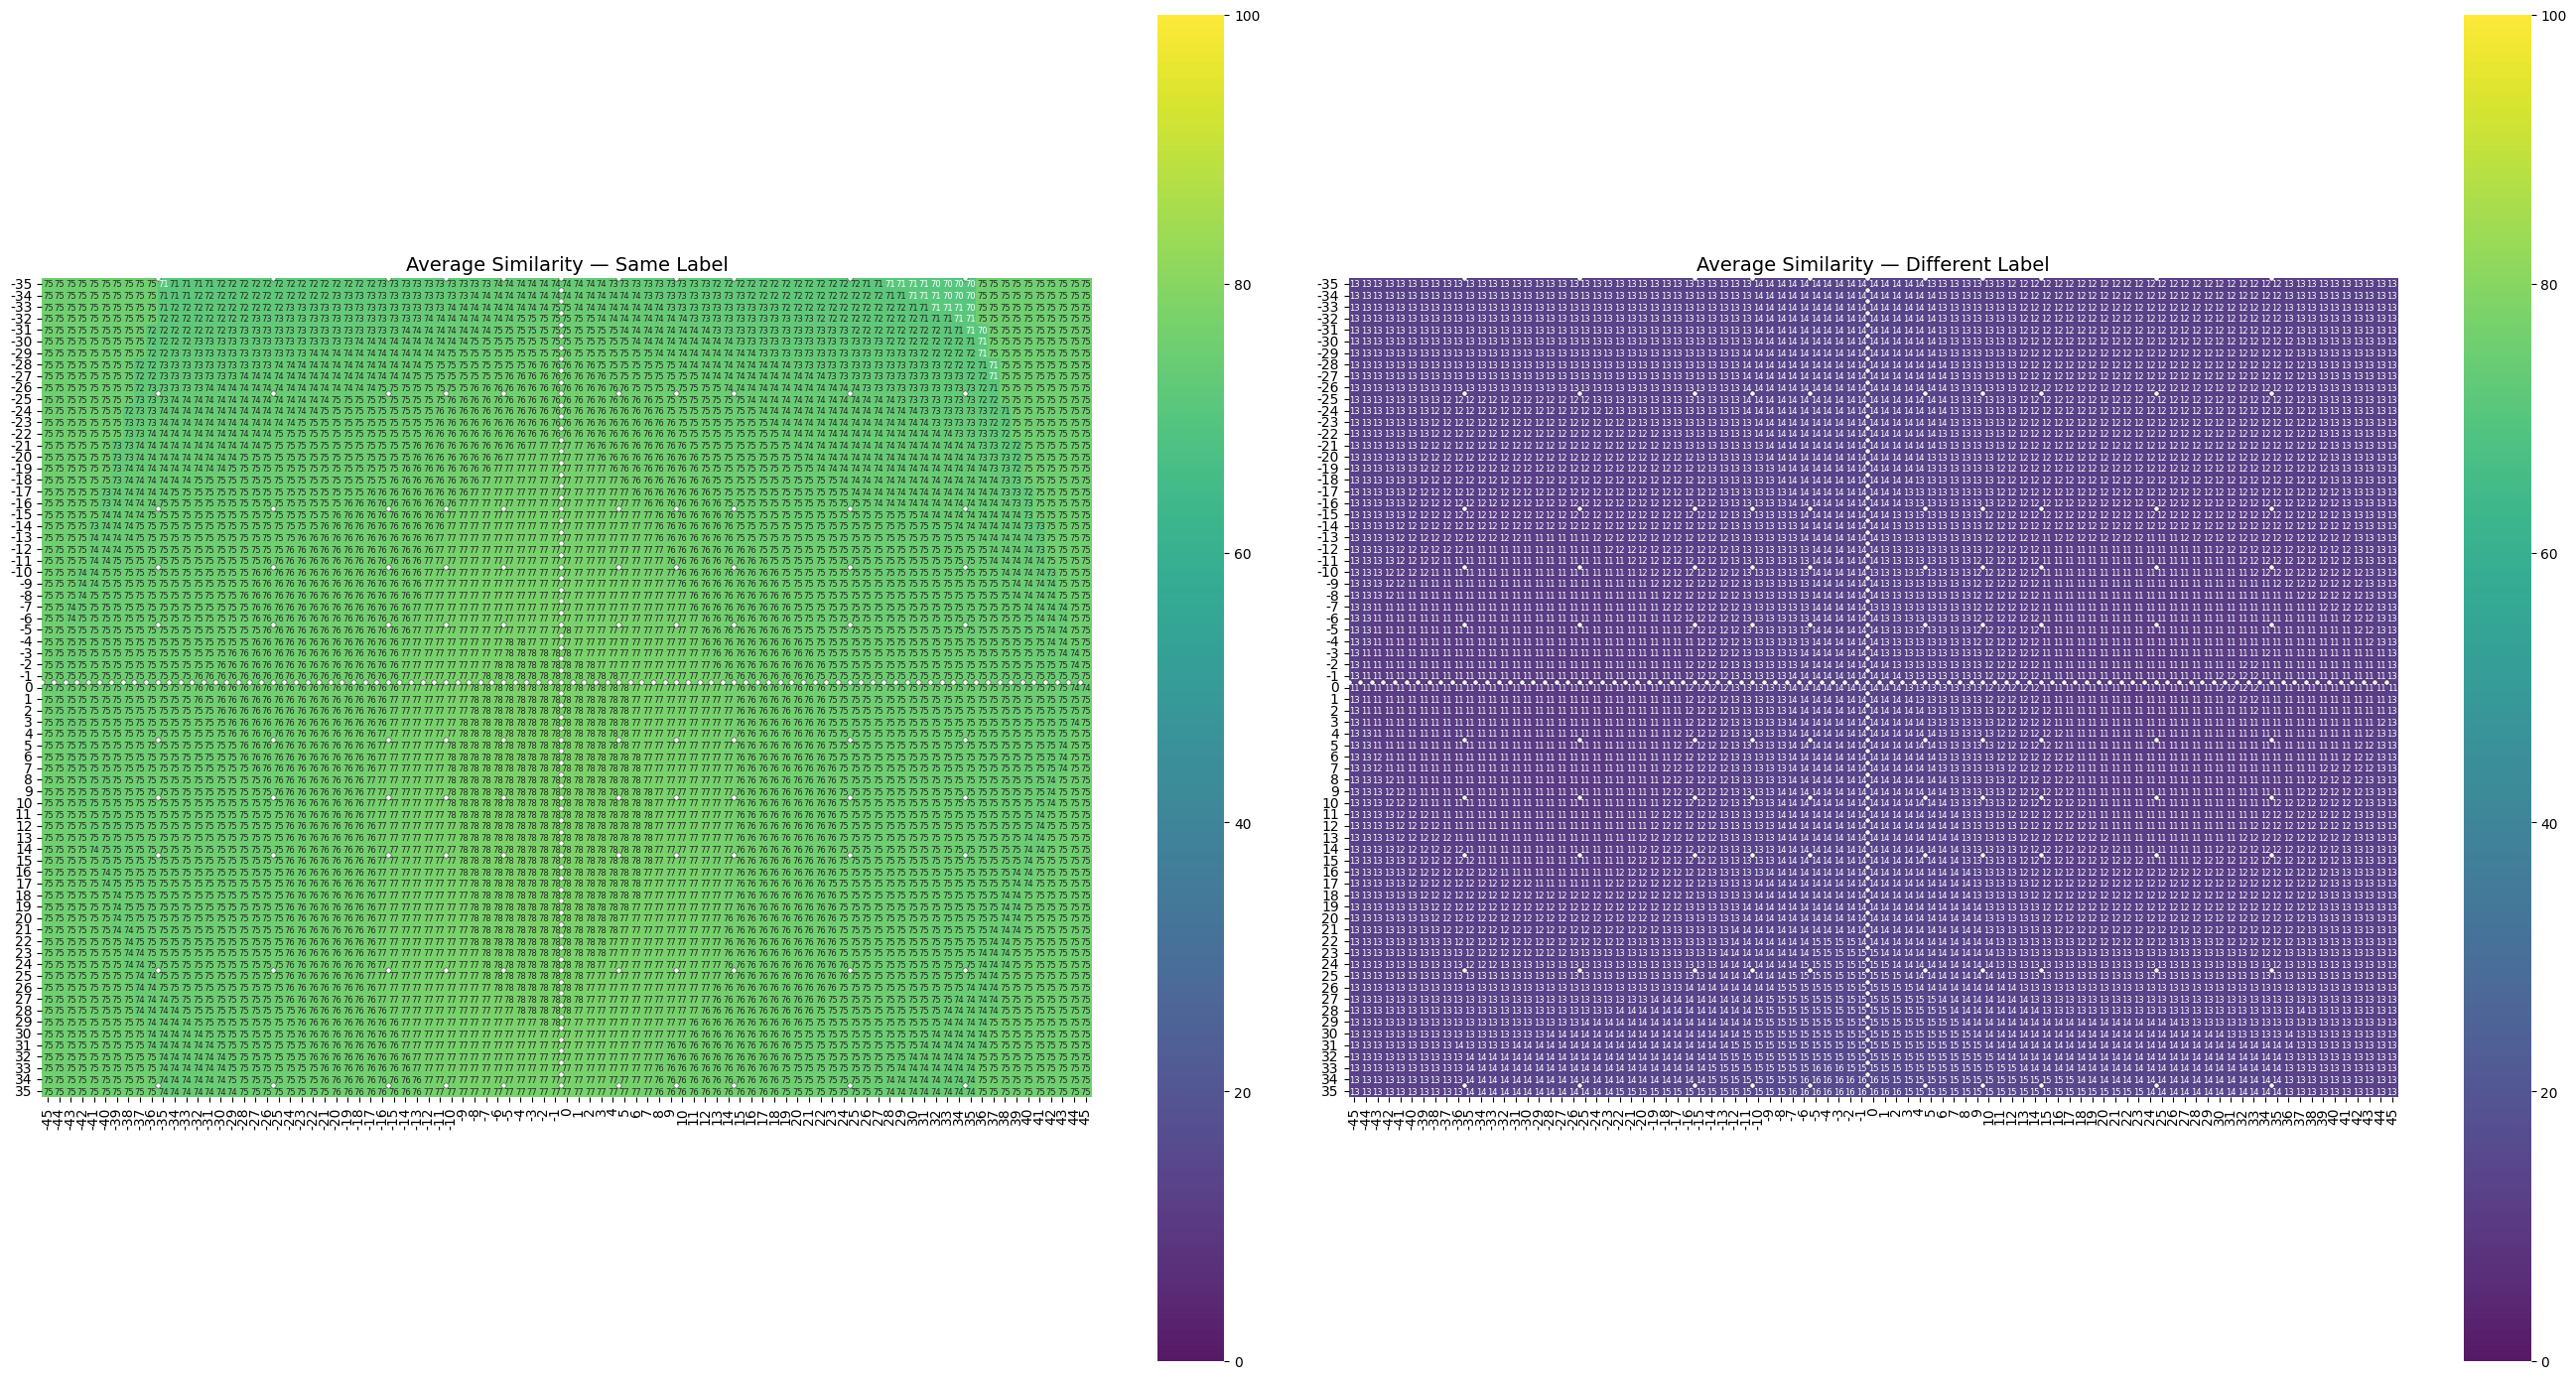

In [16]:
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-irseadafacer100", disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), visualize=True)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset, visualize=True)

Loading classes:   0%|          | 0/1041 [00:00<?, ?it/s]

Compute distances: 100%|██████████| 19786/19786 [08:54<00:00, 37.05it/s]


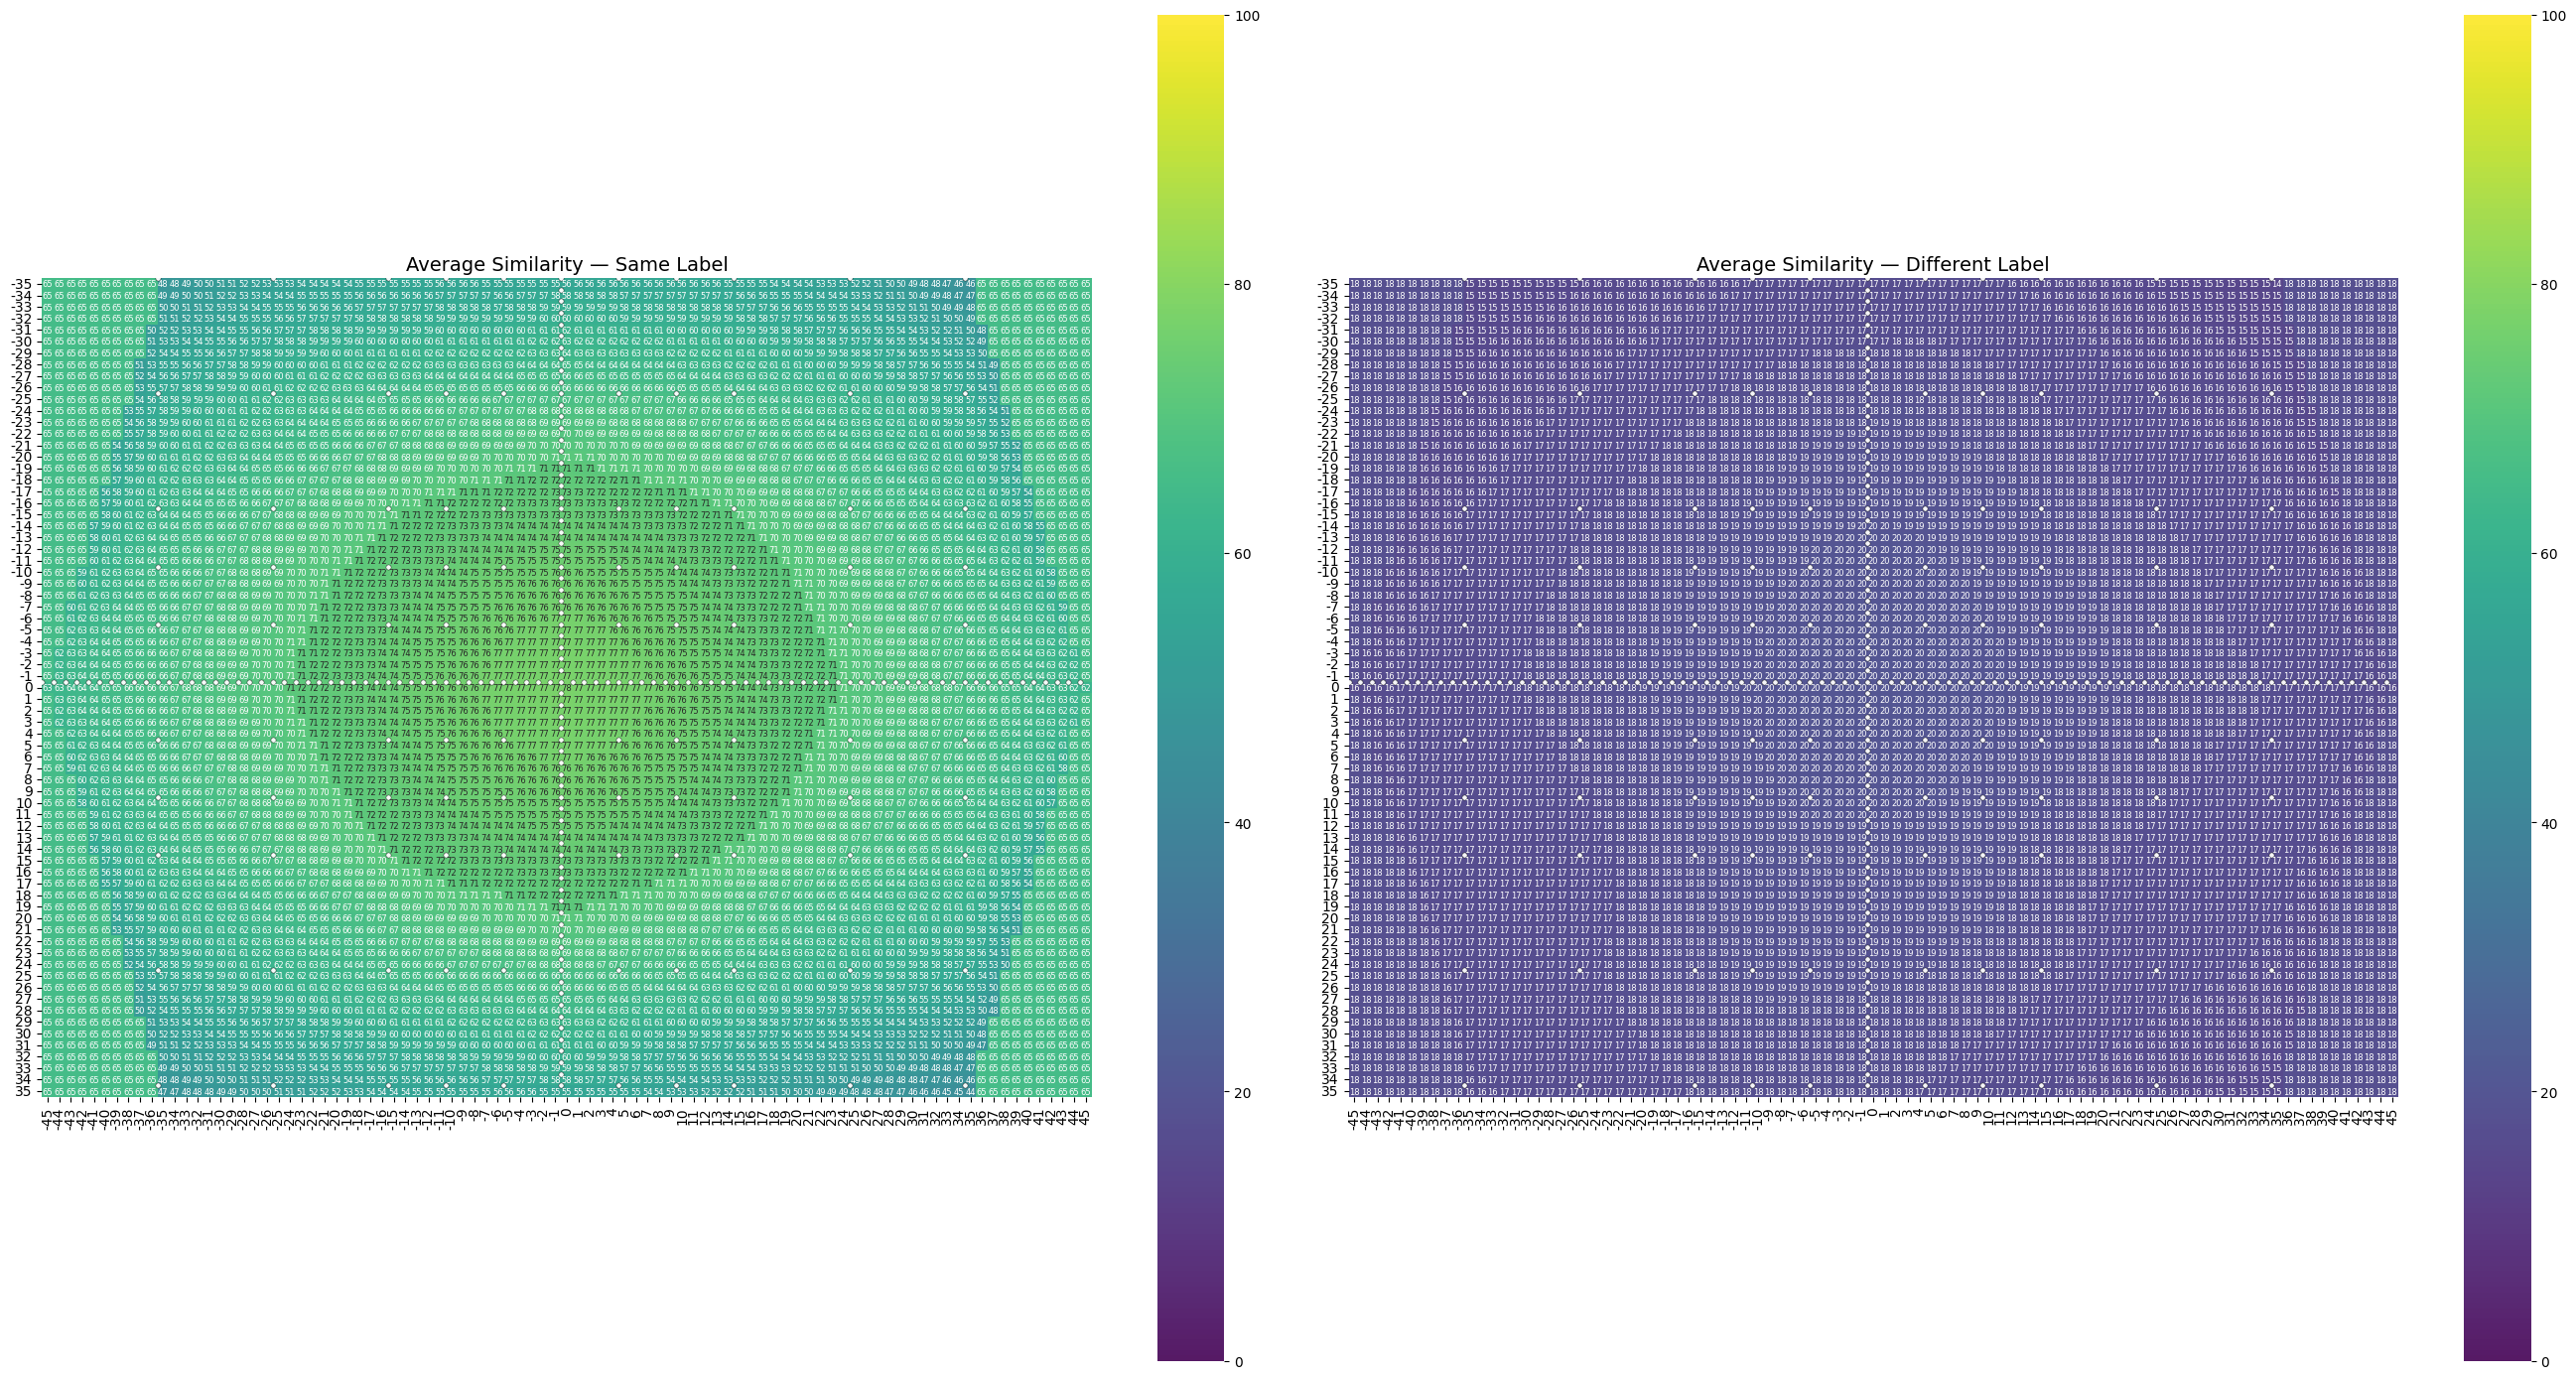

Compute distances: 100%|██████████| 19786/19786 [13:35<00:00, 24.27it/s]


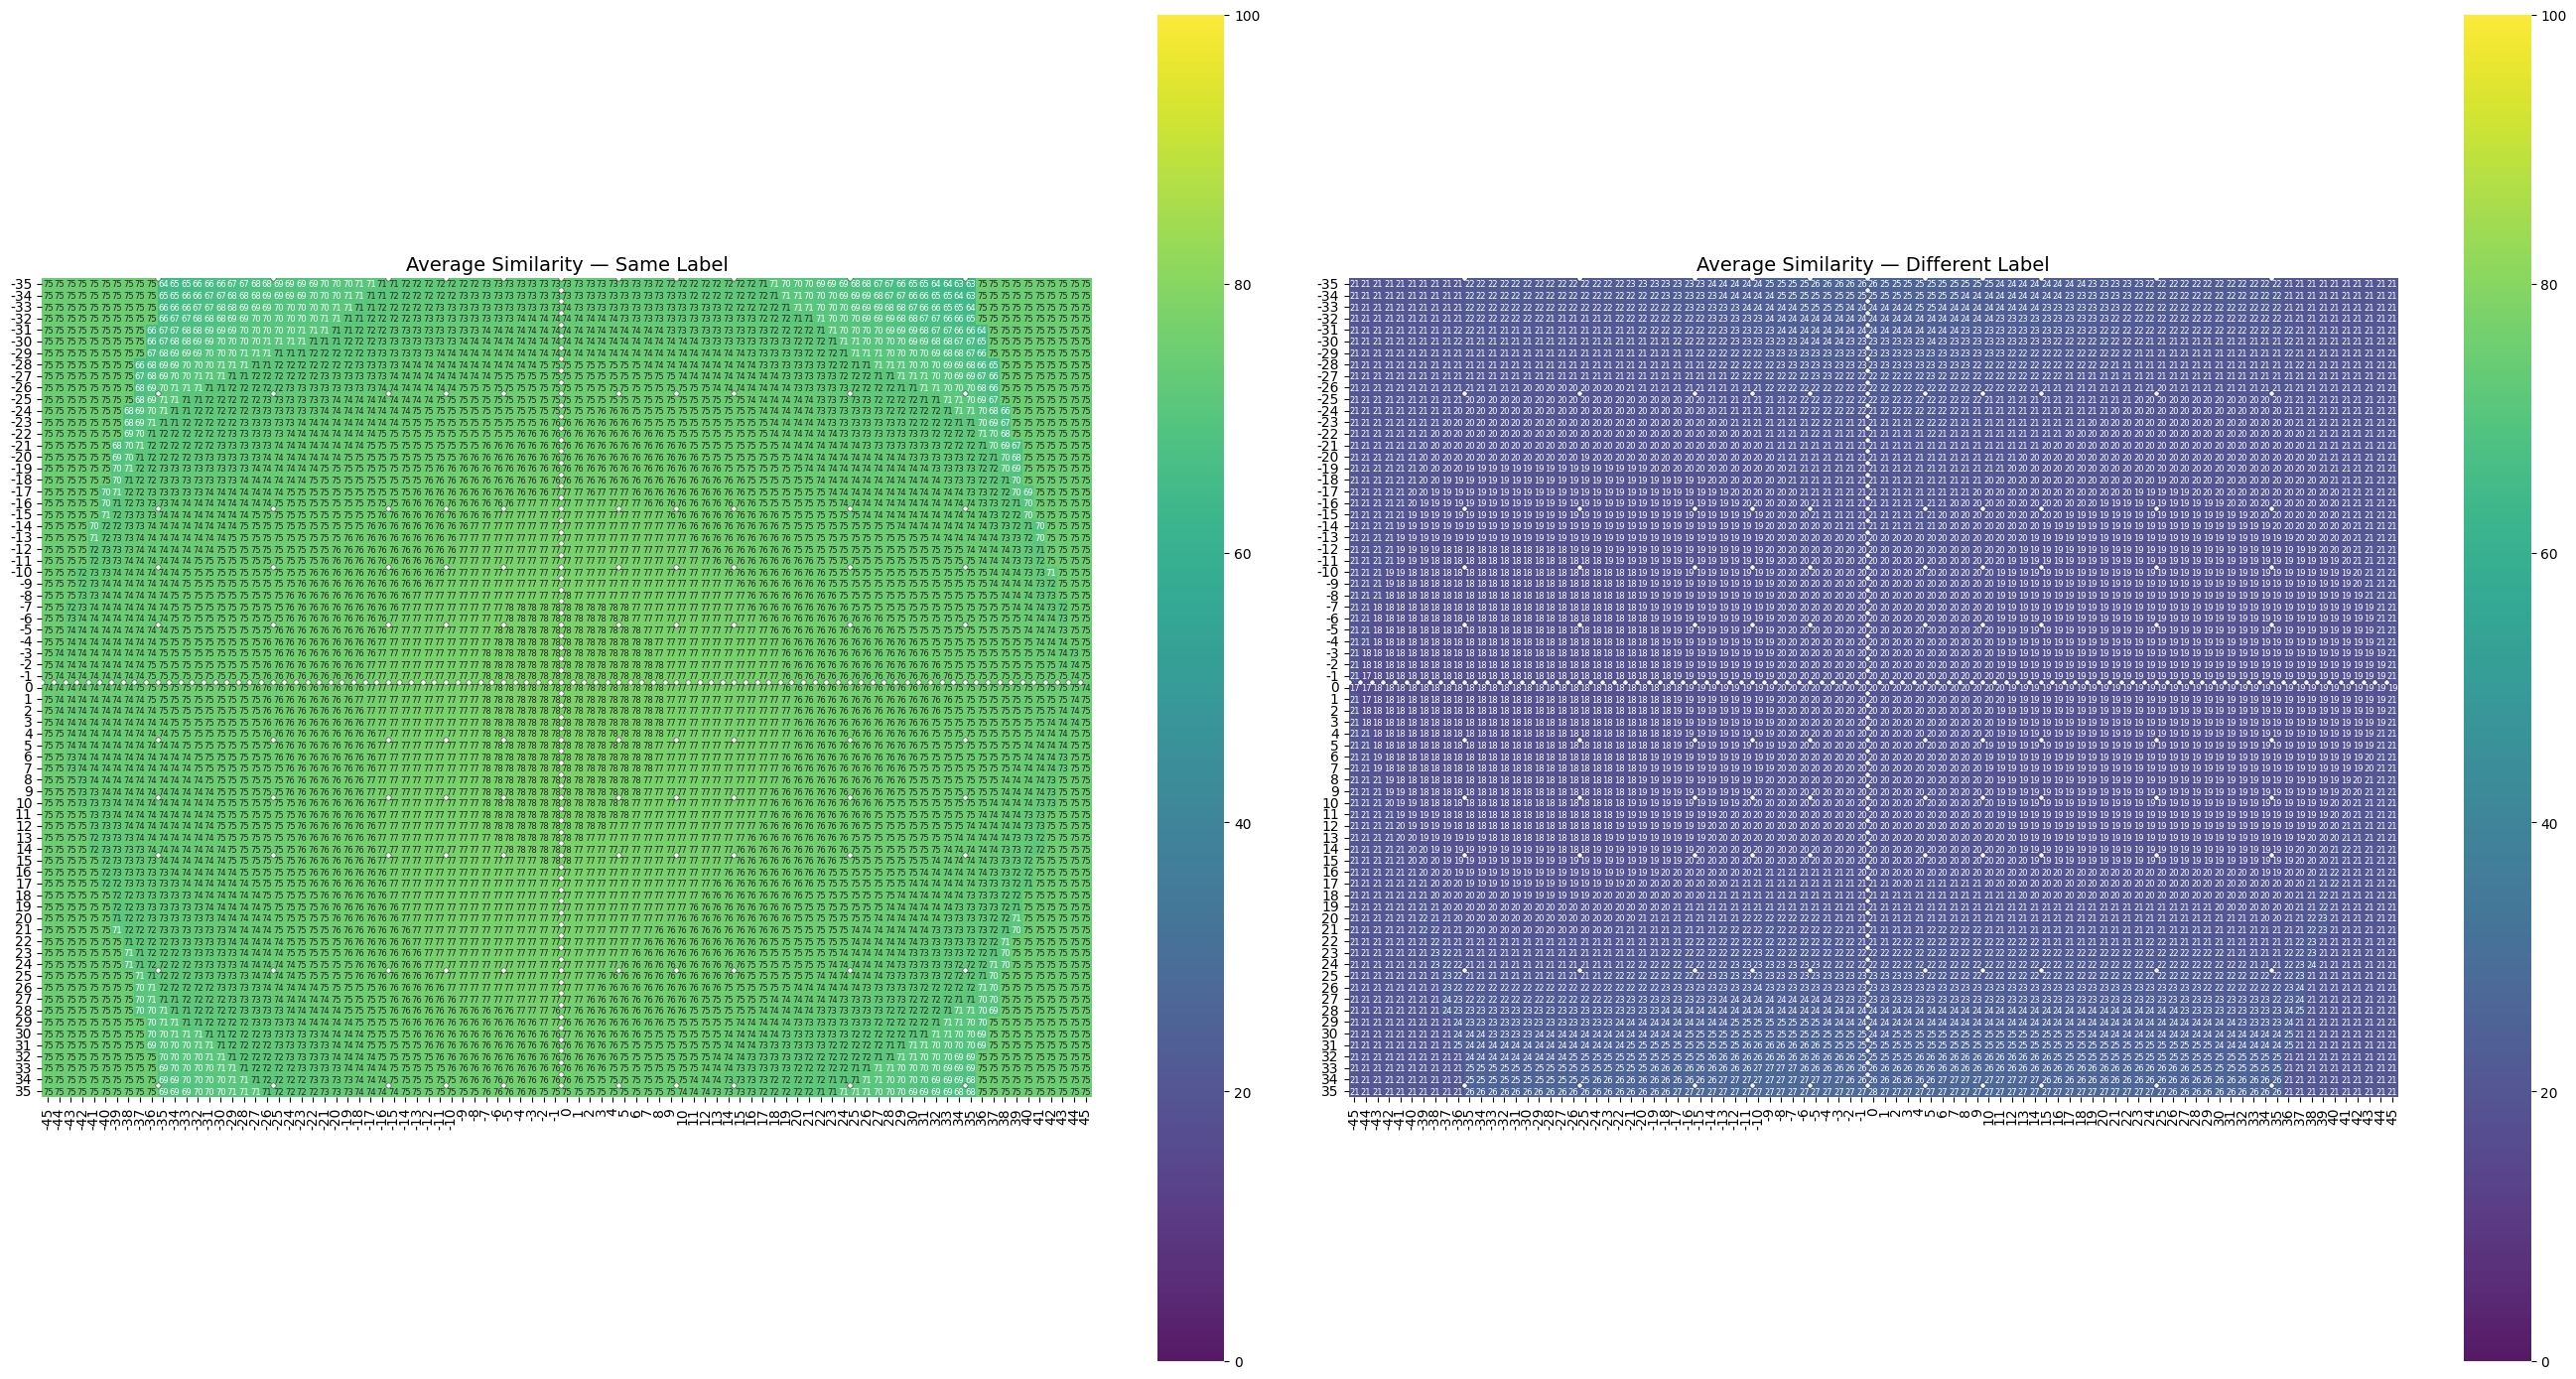

In [17]:
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-irseglintr18", disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), visualize=True)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:01<00:00, 41.06it/s]


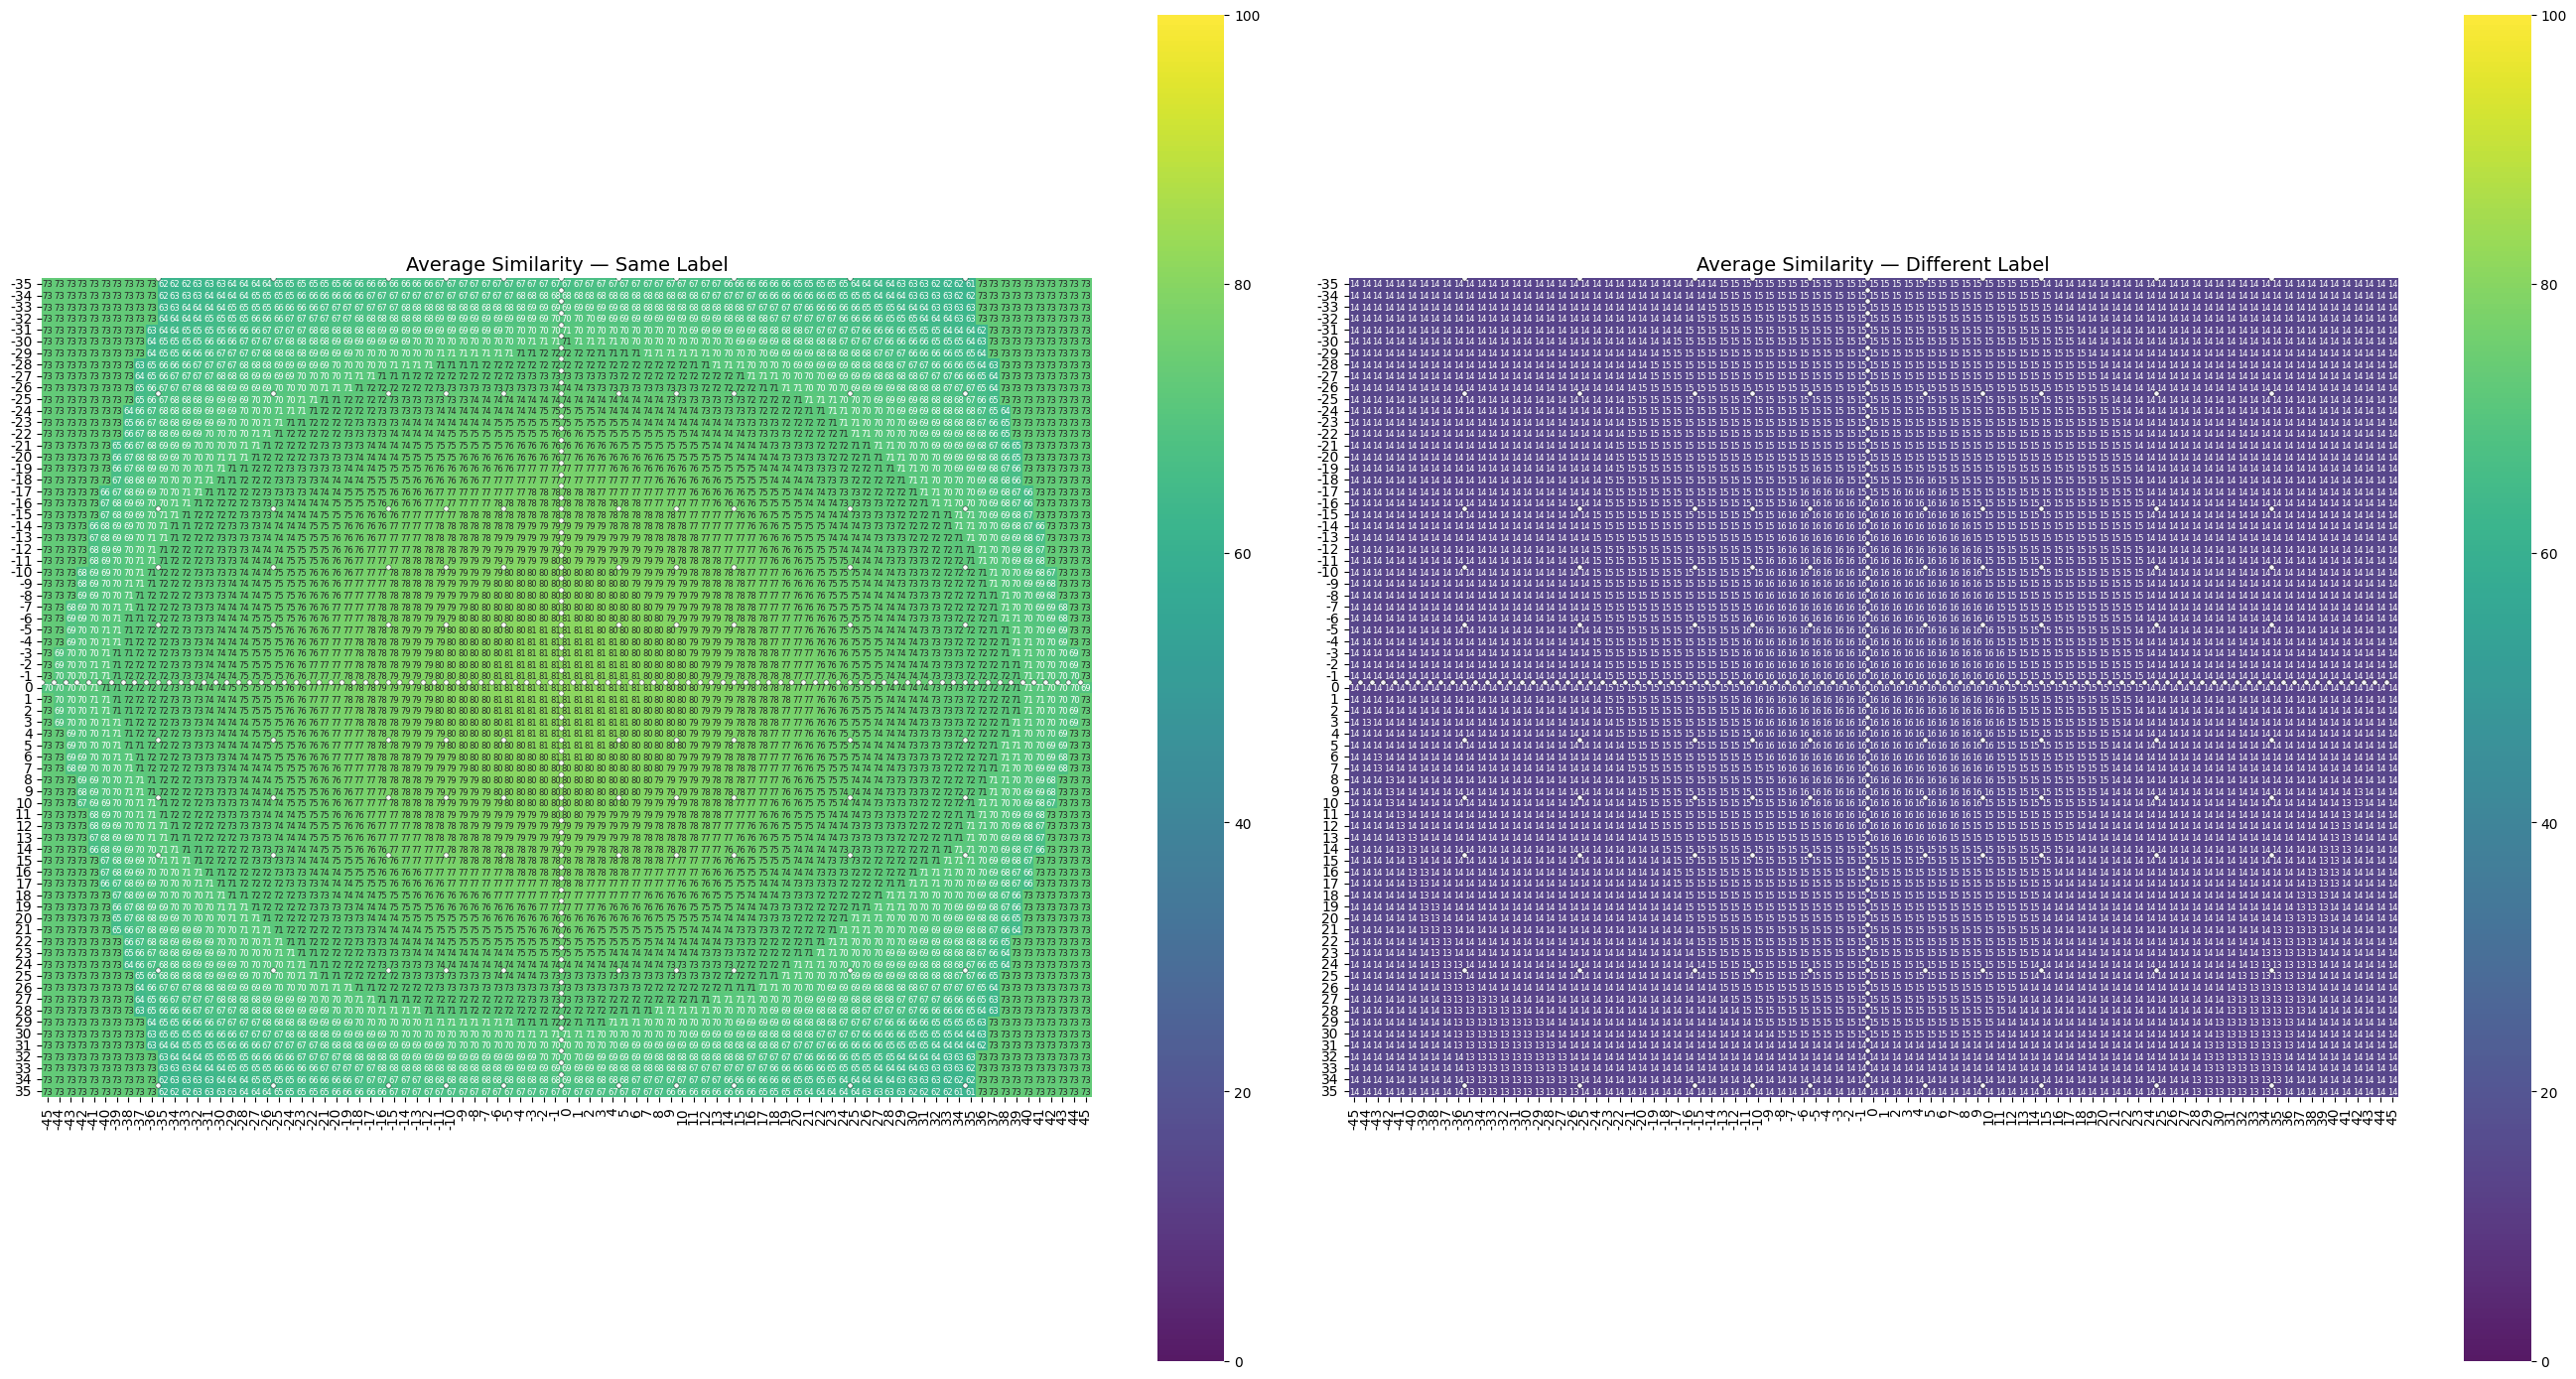

Compute distances: 100%|██████████| 19786/19786 [13:36<00:00, 24.25it/s]


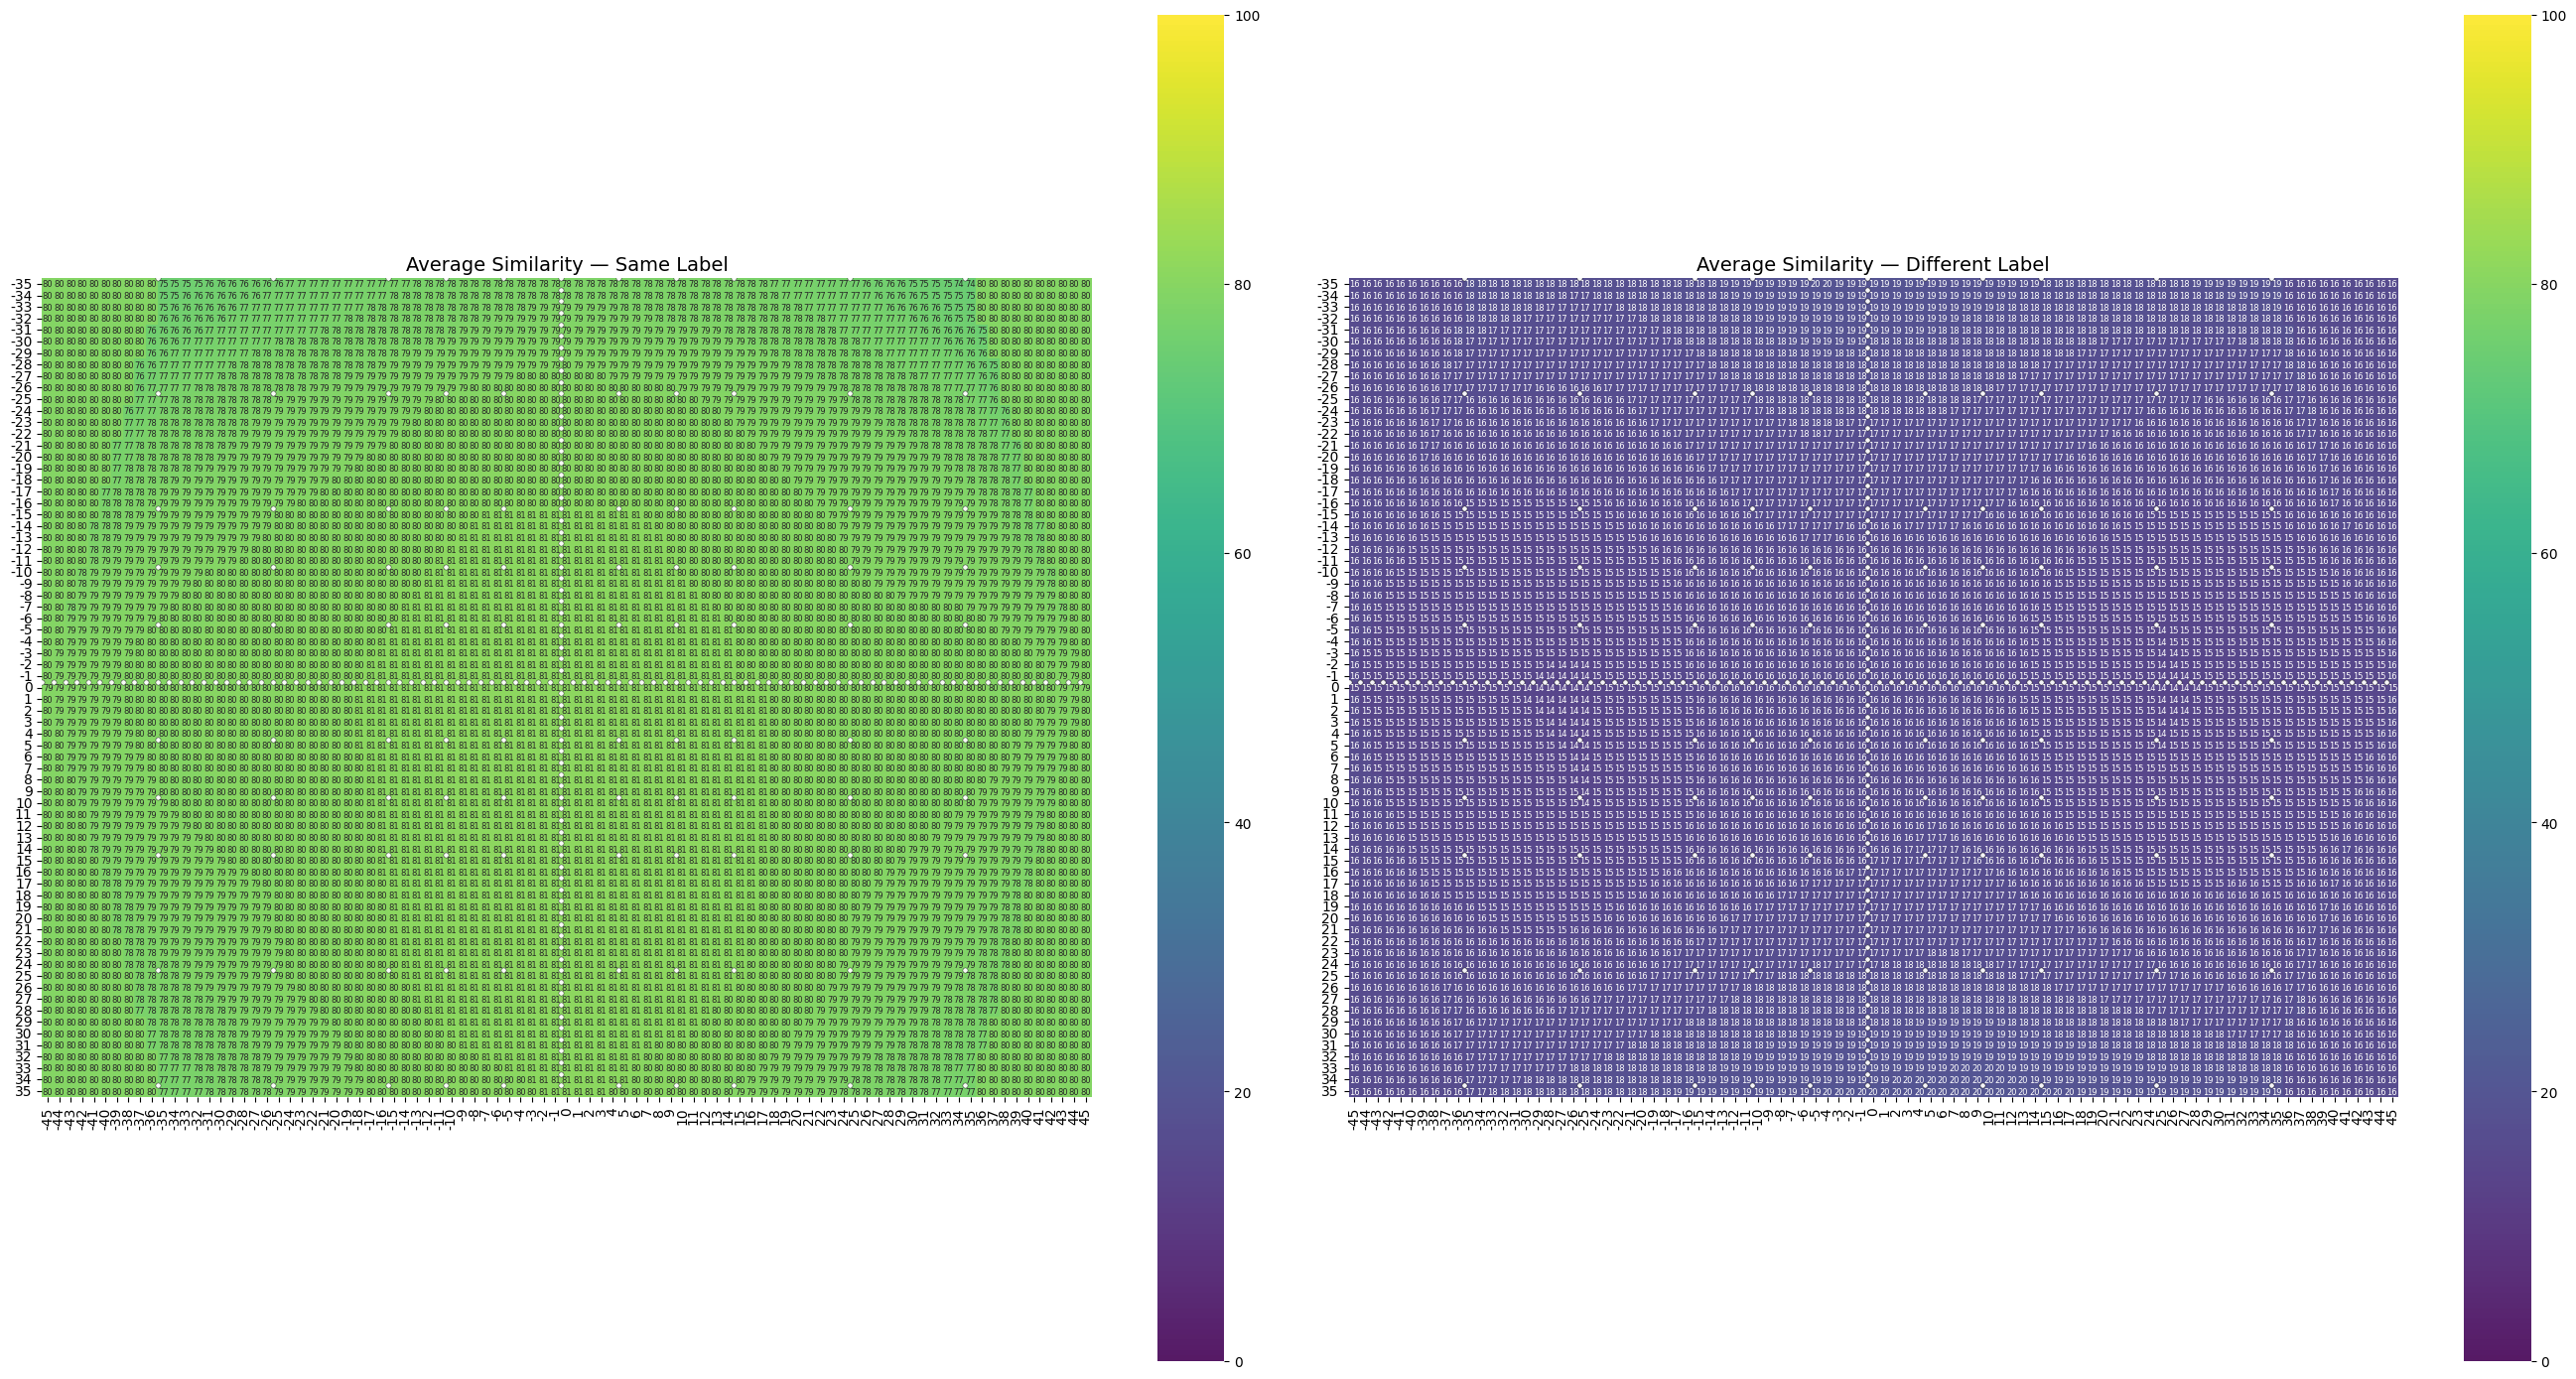

In [18]:
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-irseglintr100", disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), visualize=True)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset, visualize=True)

Compute distances: 100%|██████████| 19786/19786 [08:58<00:00, 36.76it/s]


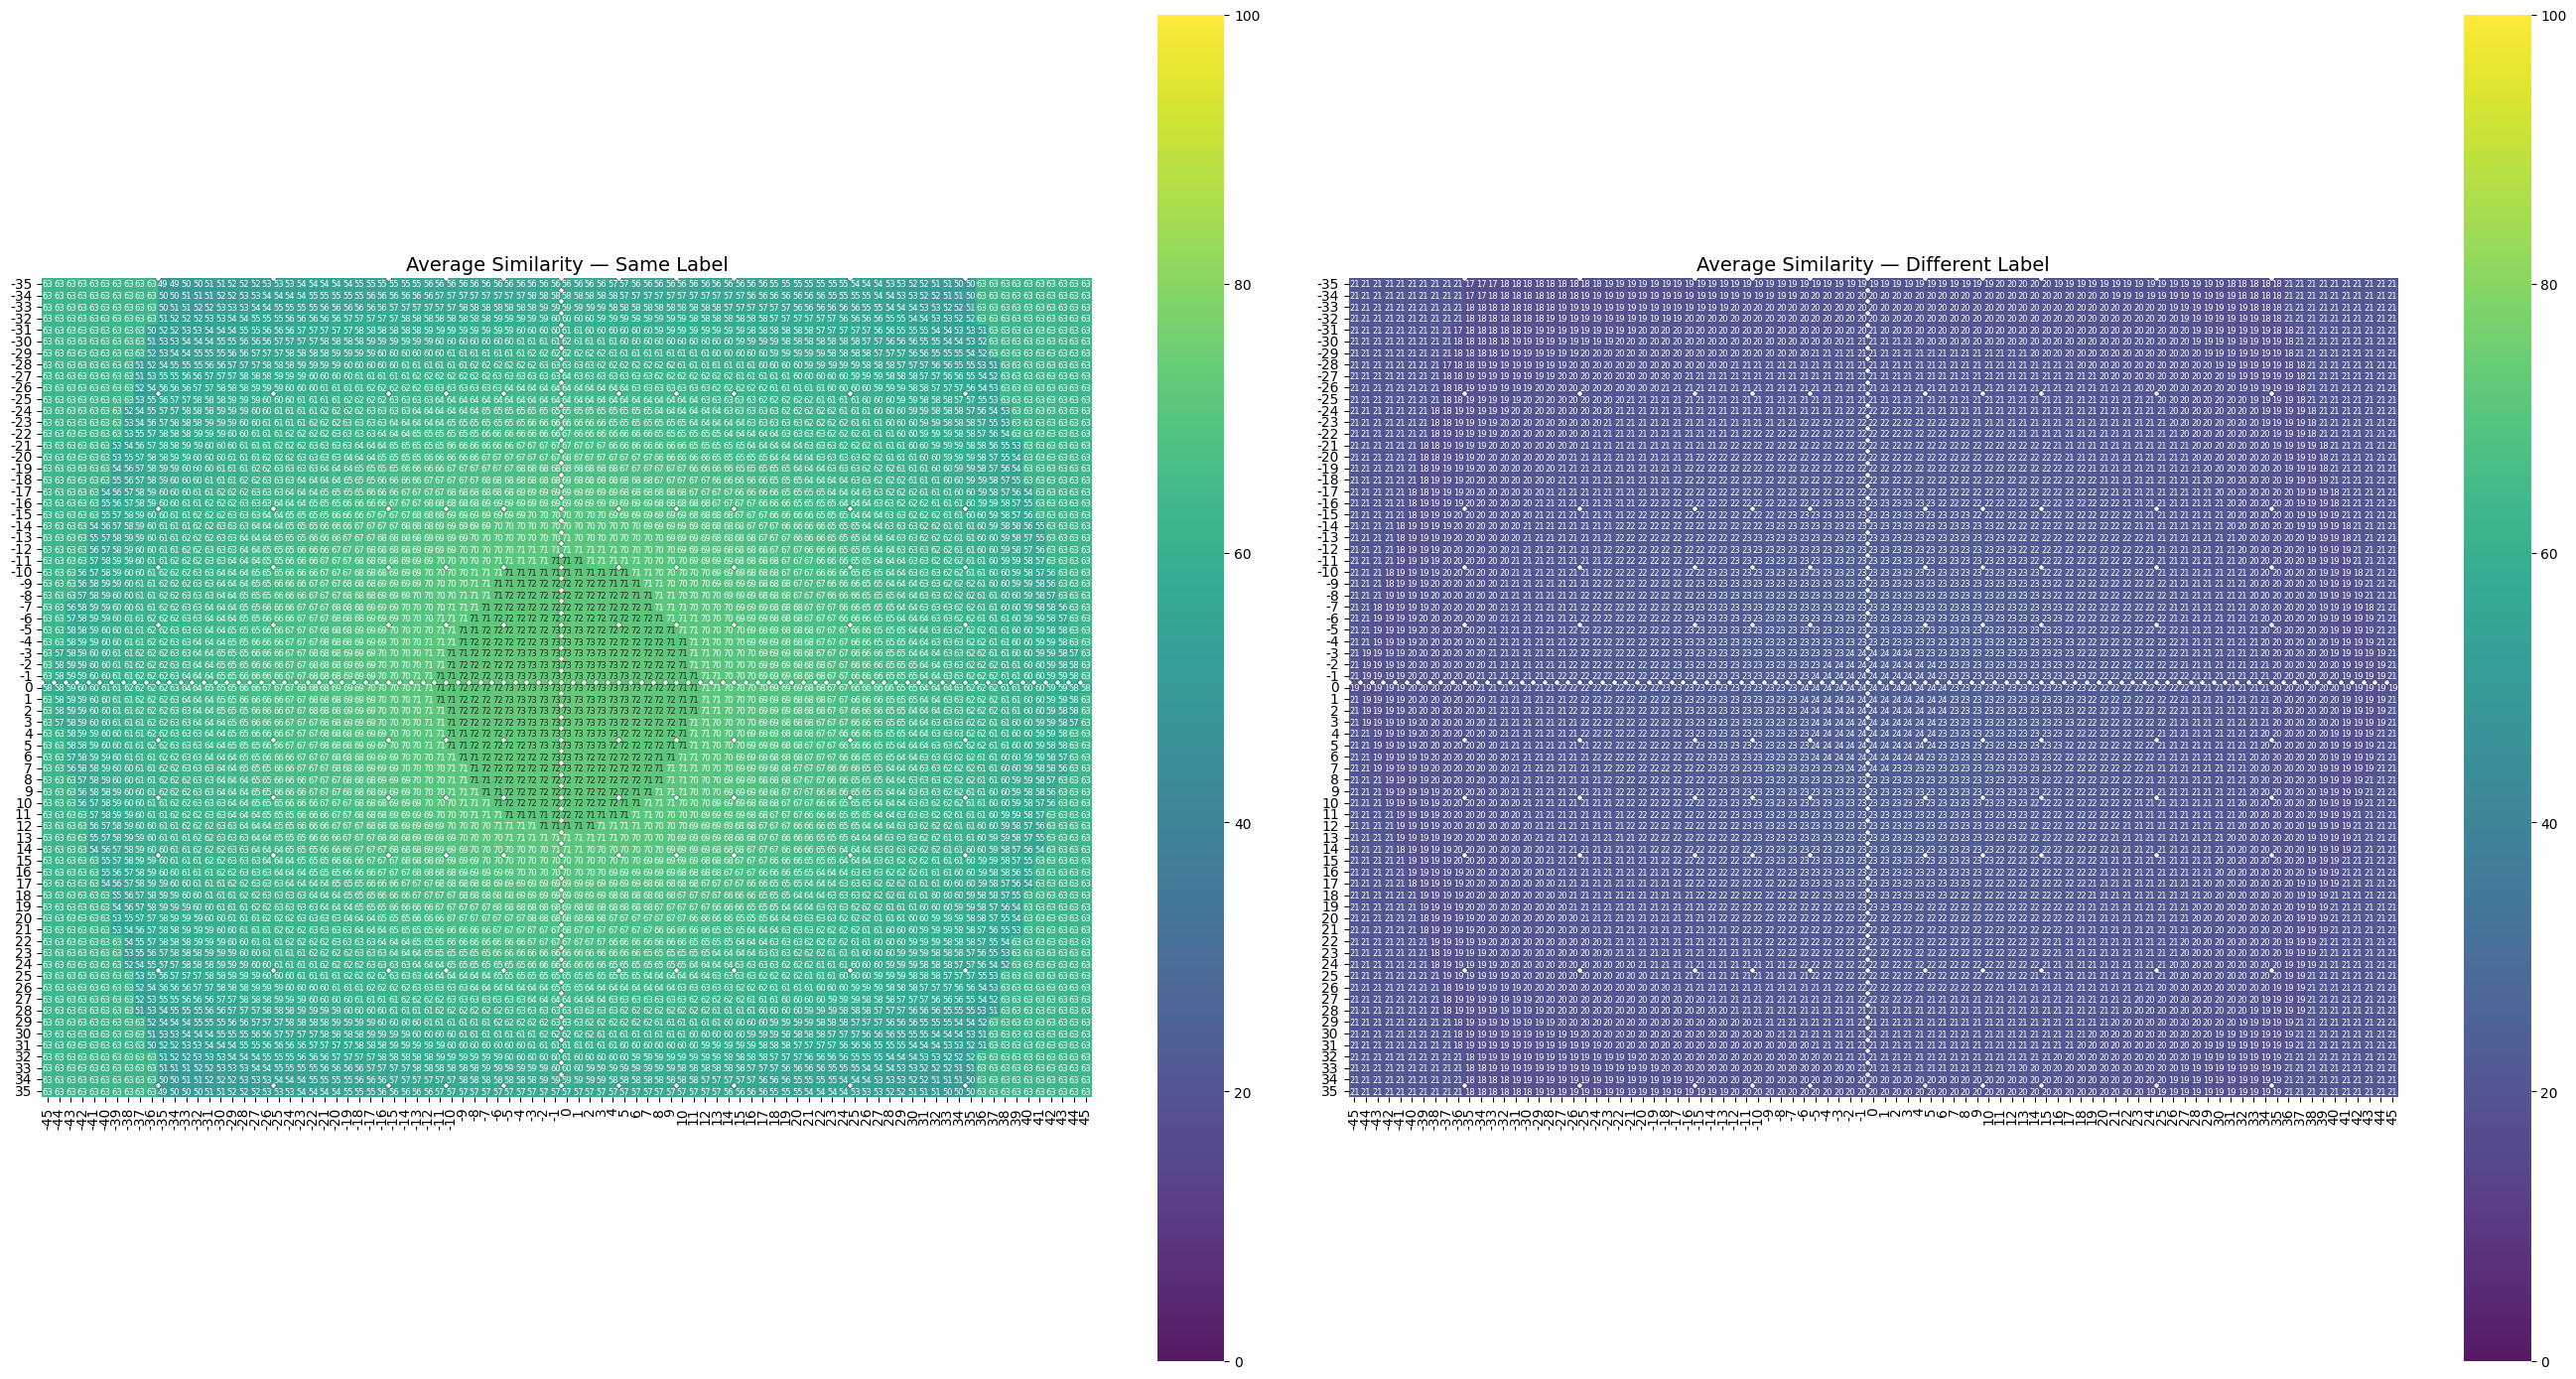

Compute distances: 100%|██████████| 19786/19786 [14:15<00:00, 23.13it/s]


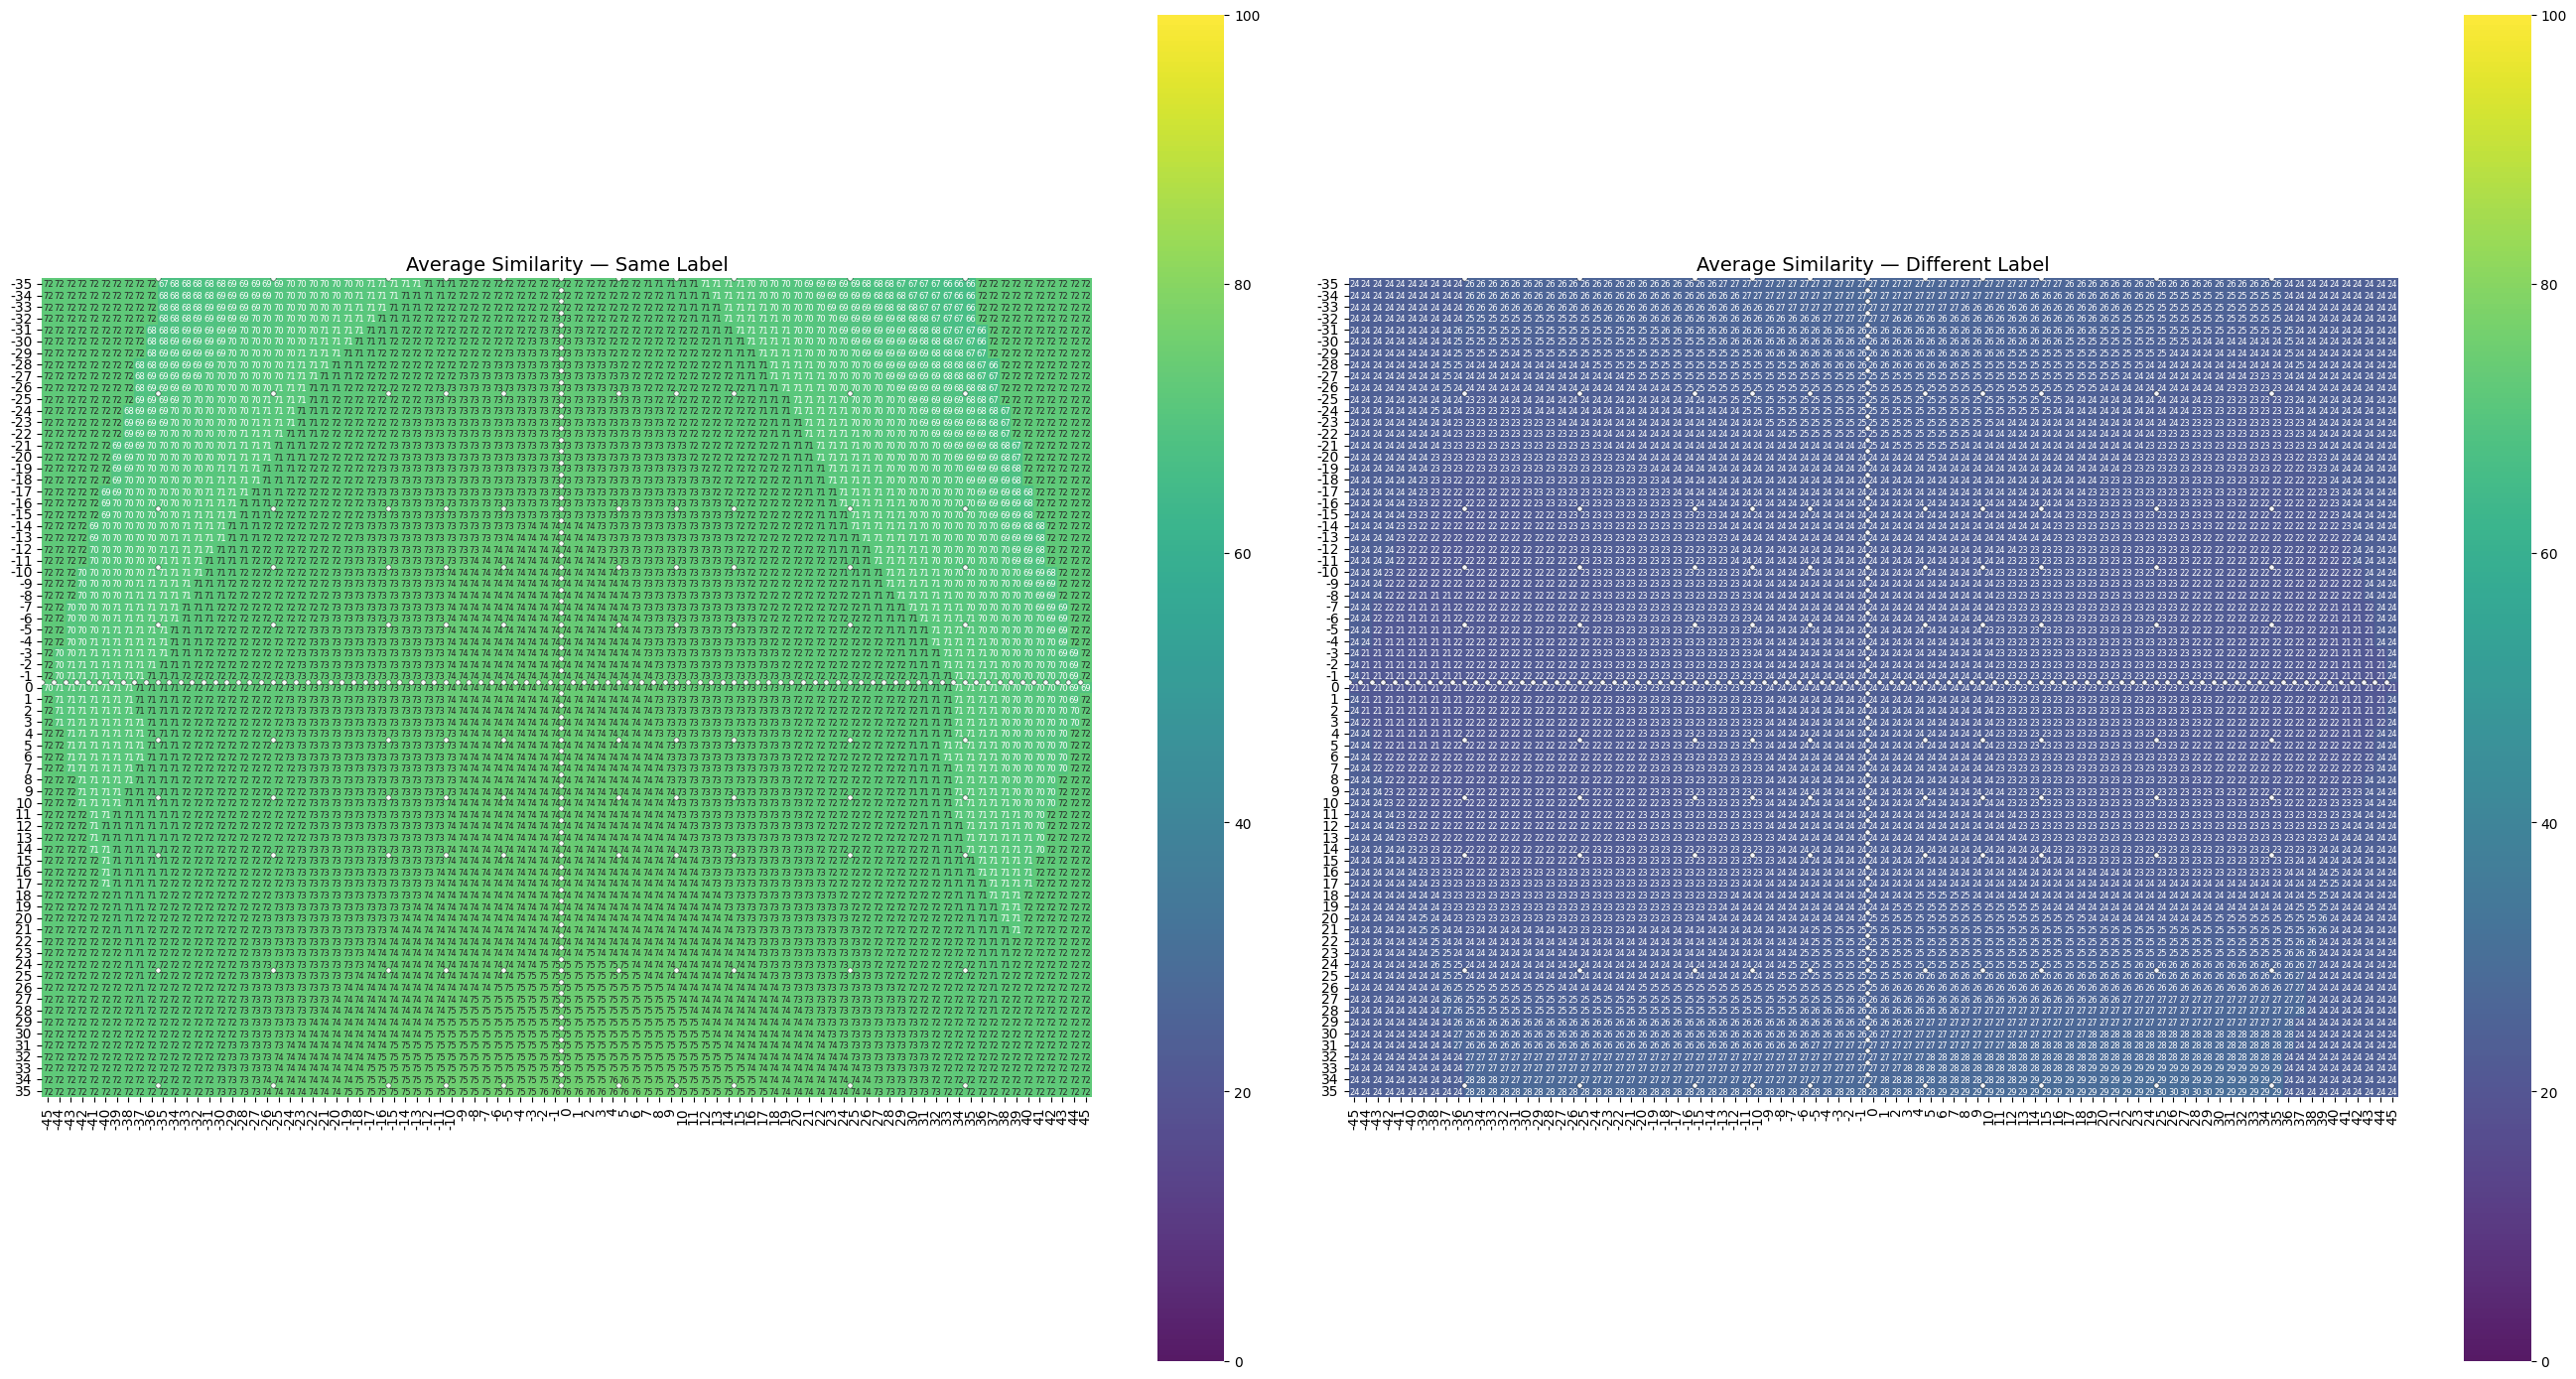

In [19]:
dataset = EmbeddingDataset(r"F:/Face/data/dataset15_emb/rgb_bff_crop261_emb-irsehyperr50", disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset, center_pose=(0, 0), visualize=True)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset, visualize=True)